In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
import pandas as pd

sns.set(context="talk")

In [2]:
trainer_dict = {
    "Distributed": "PyTorch DDP",
    "Horovod": "Horovod",
    "local": "Local Training"
}

In [60]:
def create_measurement_df(file_name):
    with open(file_name) as f:
        results = json.load(f)['results']
    trainer = []
    nodes = []
    batch_size = []
    slots = []
    seconds = []
    memory = []
    
    regex = re.compile(r'0: Memory Usage: (\d+\.\d+), Training Duration: (\d+\.\d+)')

    for result in results:
        config = result['config']
        parsed_regex = regex.search(result['stderr'])
        trainer.append(config['trainer'].capitalize())
        nodes.append(config['hosts'])
        batch_size.append(config['parameters']['--batch-size'])
        slots.append(config["slots"])
        seconds.append(float(parsed_regex.group(2)))
        memory.append(float(parsed_regex.group(1)))
    return pd.DataFrame({"Trainer": trainer, "Nodes": nodes, "Batches": batch_size, "Slots": slots, "Training Time": seconds, "Memory Usage": memory})

def create_heatmap(data, measurement):
    base = data[data["Slots"] == 1]
    for trainer in ["Distributed", "Horovod"]:
        df = base[base["Trainer"] == trainer]
        df = df.drop(["Slots", "Trainer"], axis=1).groupby(["Nodes", "Batches"]).mean().unstack()[measurement].T
        f = plt.figure(figsize=(15, 6), dpi= 300, facecolor="w", edgecolor="w")
        ax = sns.heatmap(df, annot=True, fmt="6.1f", cmap="YlGnBu", square=True)
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        ax.invert_yaxis()
        ax.set_ylabel('Batch Size')
        ax.set_xlabel('# of Nodes')
        ax.set_title(f'{measurement} ({trainer_dict[trainer]})')
        
def create_point_plot(data, measurement):
    base = data[data["Slots"] == 1]
    for trainer in ["Distributed", "Horovod"]:
        df = base[base["Trainer"] == trainer]
        f = plt.figure(figsize=(15, 8), dpi= 300, facecolor="w", edgecolor="w")
        ax = sns.pointplot(x="Nodes", y=measurement, hue="Batches", data=df, ci="sd", capsize=0.1)
        ax.set_ylabel('Training Time in s')
        ax.set_xlabel('# of Nodes')
        ax.set_title(f'{measurement} ({trainer_dict[trainer]})')
        ax.legend().set_title("Batch Size")
    

def create_slot_bar_chart(df, measurement):
    df = df.groupby(["Nodes", "Batches", "Slots"]).mean().reset_index()
    df = df[(df["Nodes"] != 8) & (df["Slots"] != 2)]
    fig = plt.figure(figsize=(15, 8), dpi= 300, facecolor="w", edgecolor="w")
    ax = sns.barplot(x="Nodes", y=measurement, data=df, hue="Slots", ci=None)       
    ax.set_xlabel("# of Nodes")
    ax.set_ylabel("Training Time in s")
    ax.set_title(f"{measurement} for Nodes and Slots")

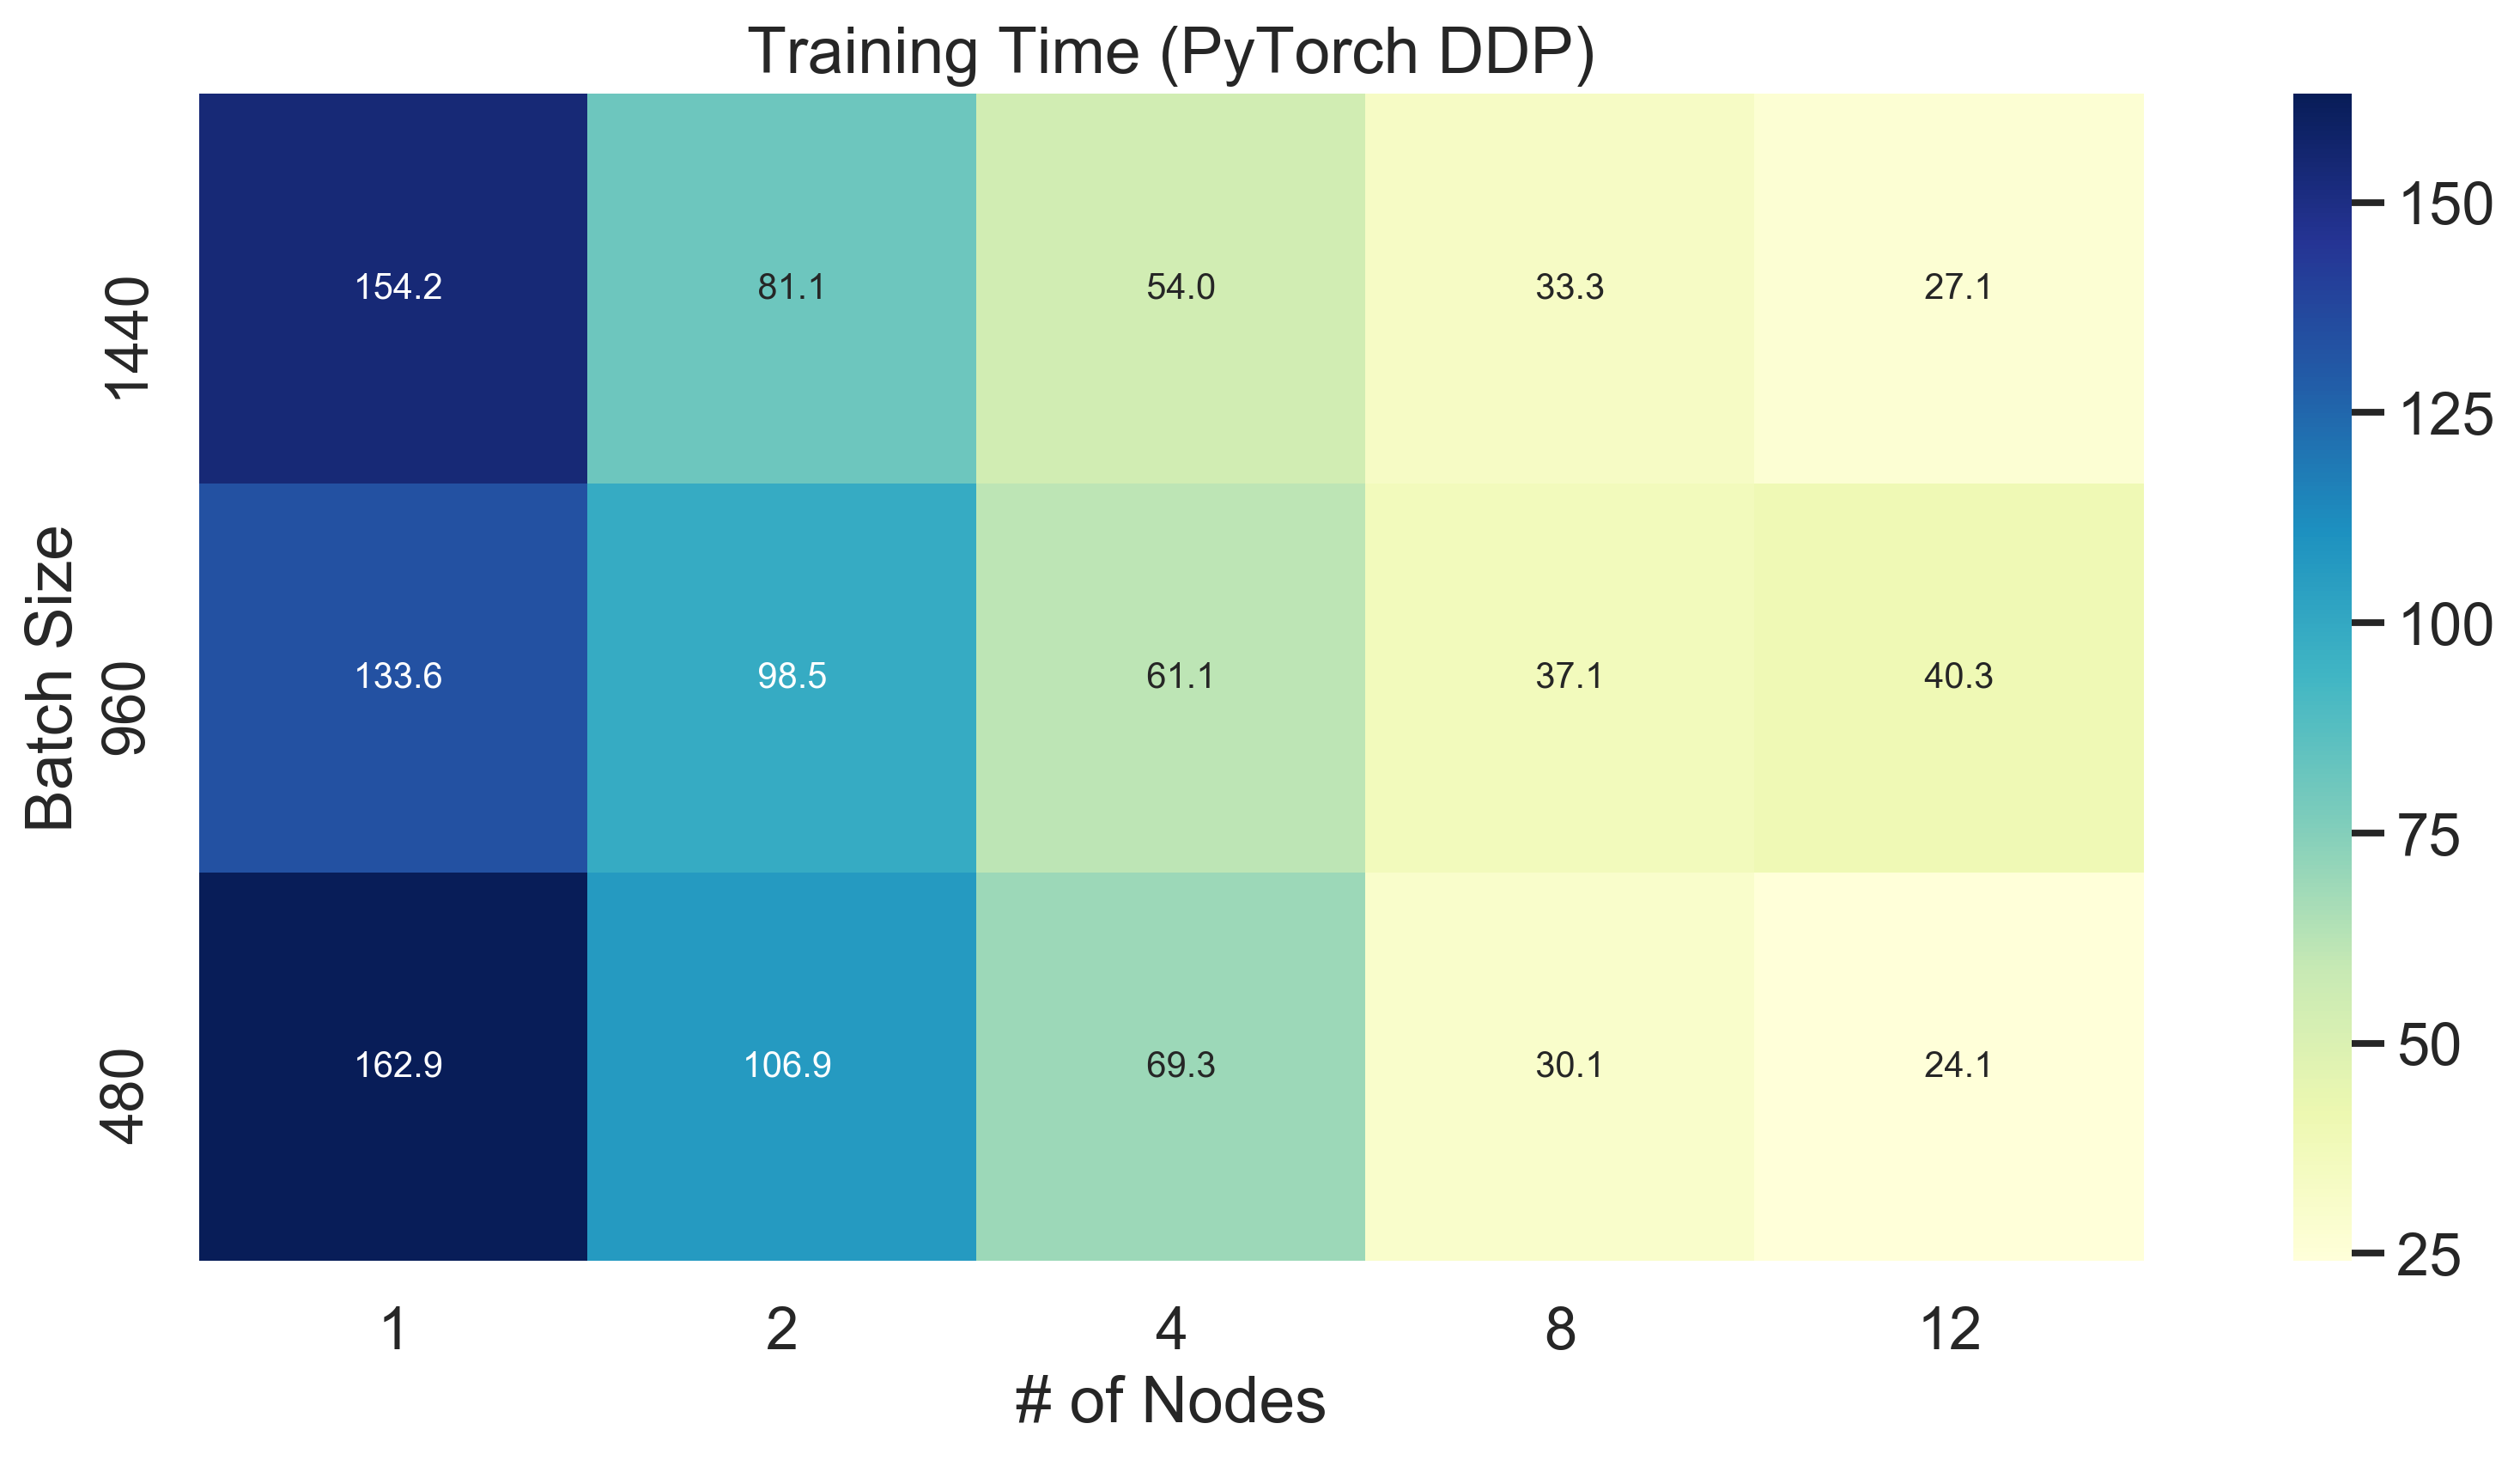

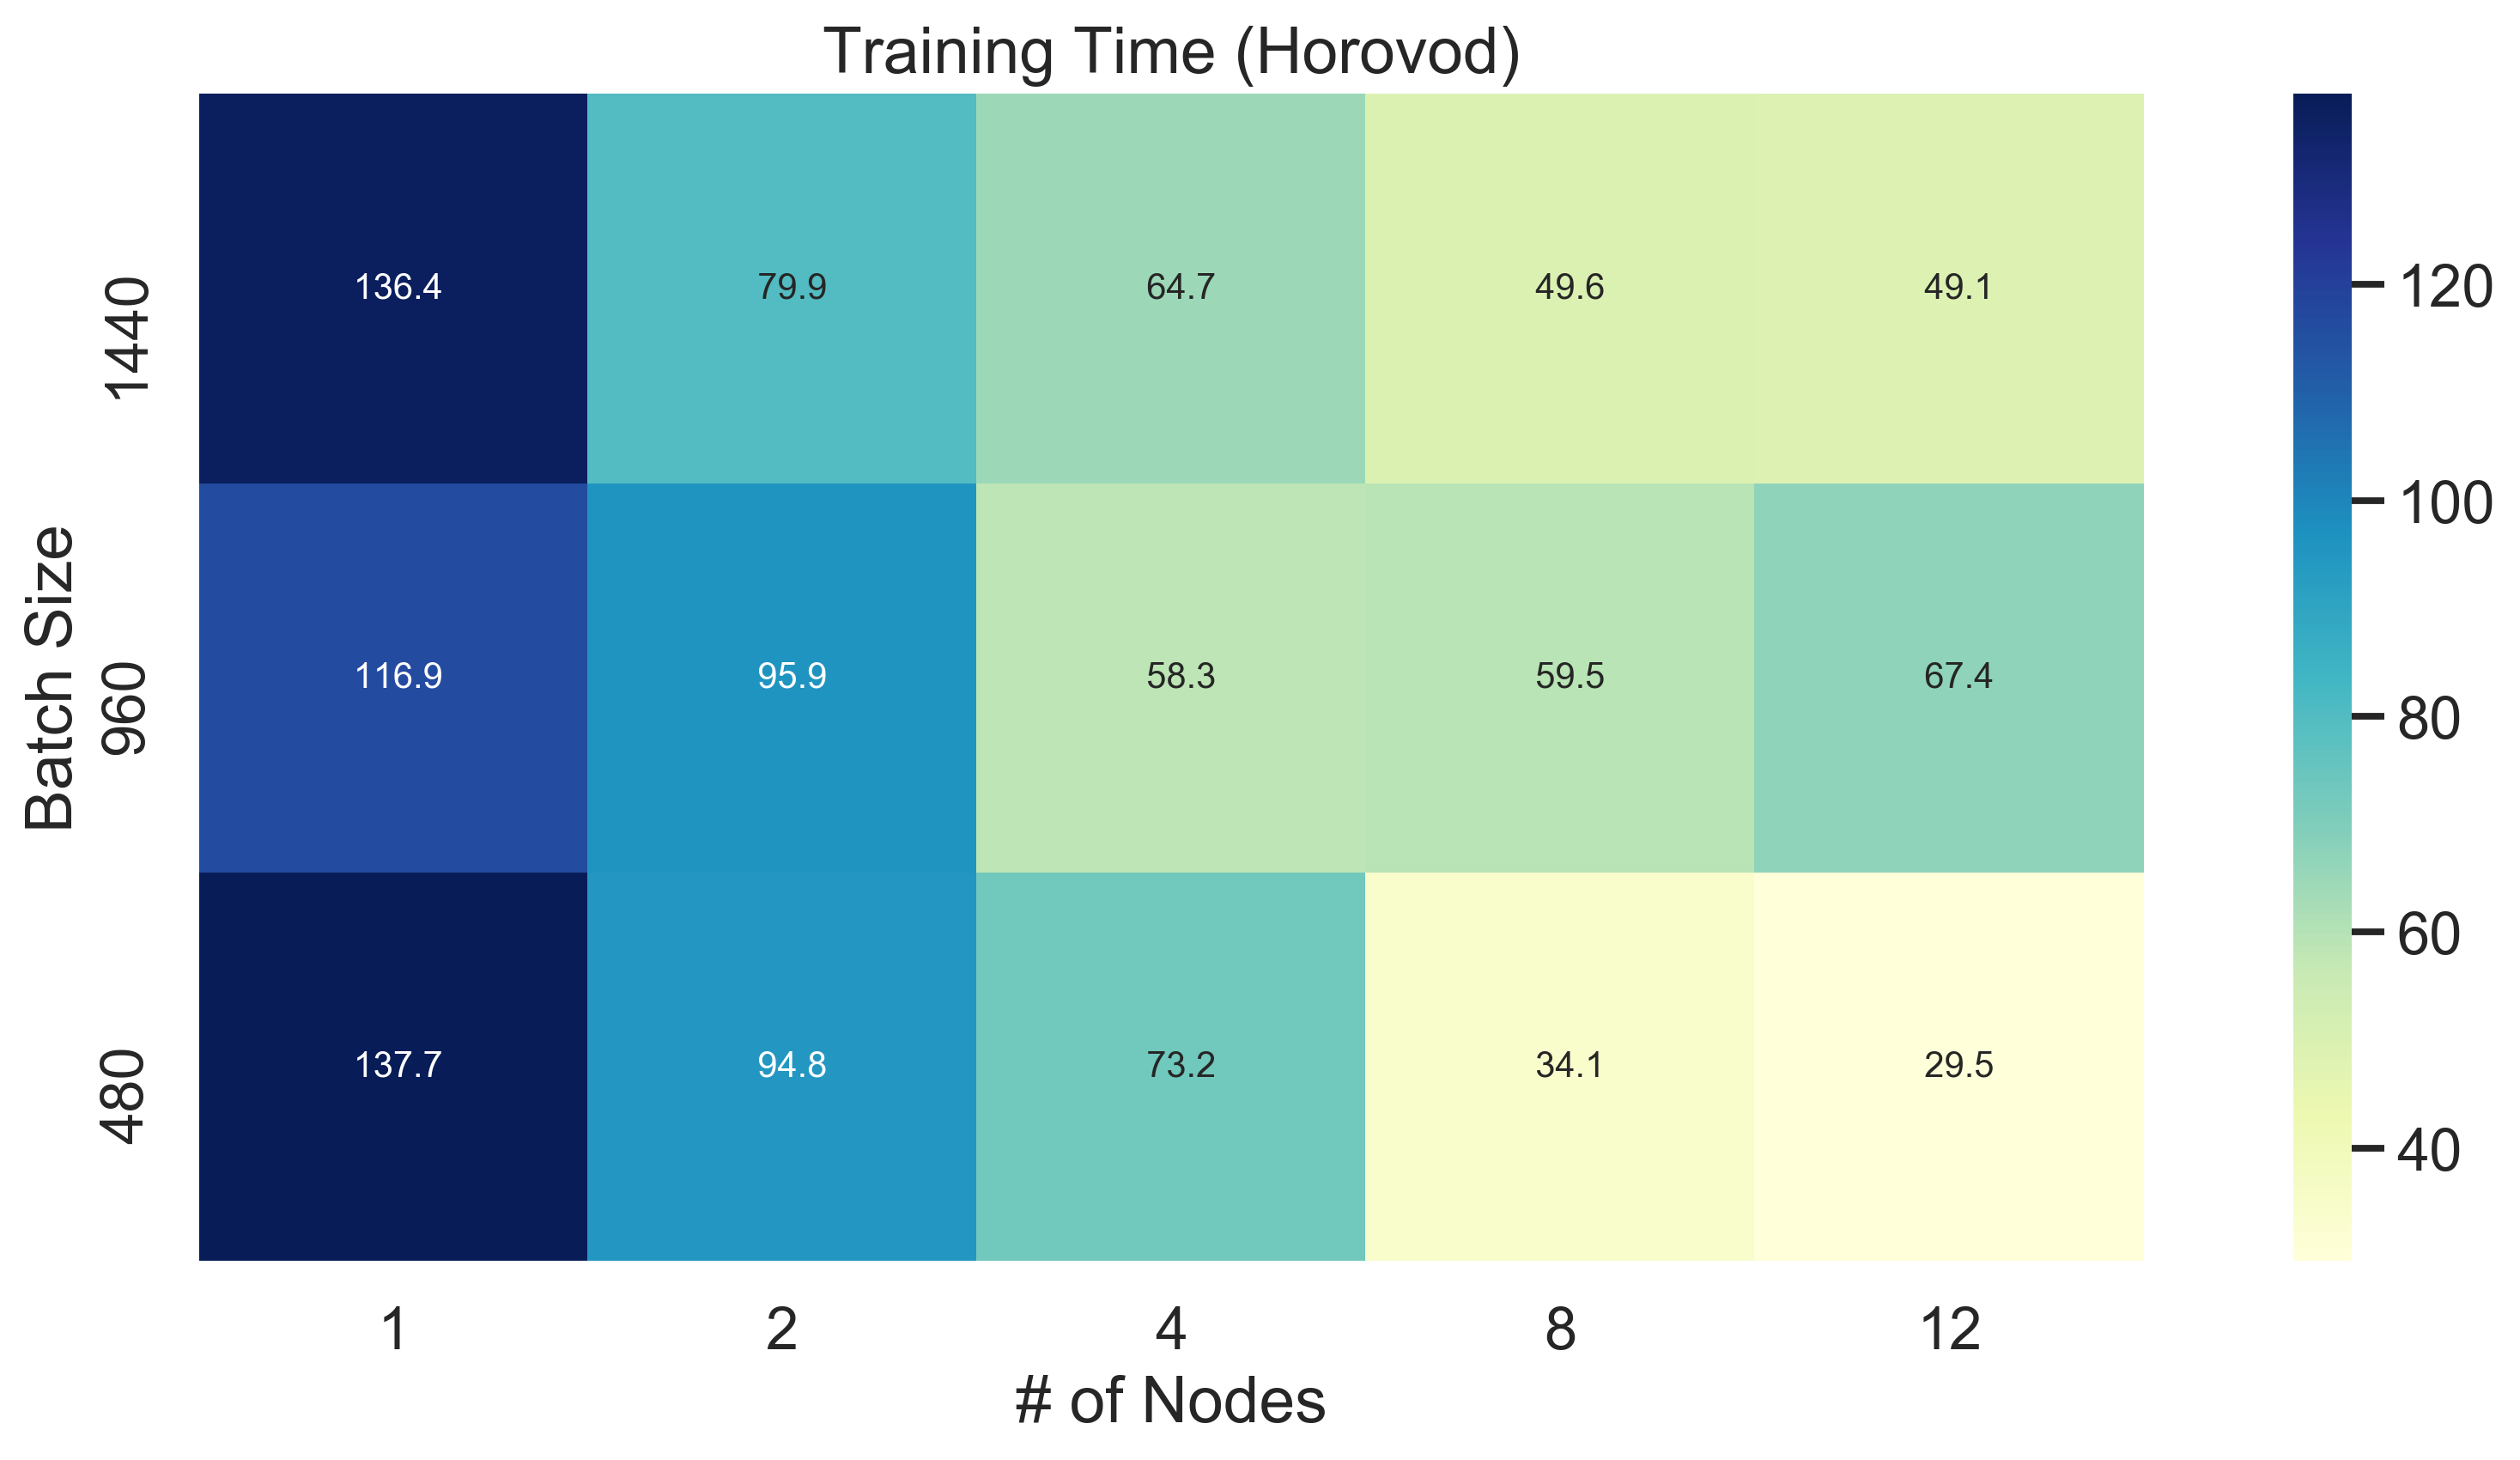

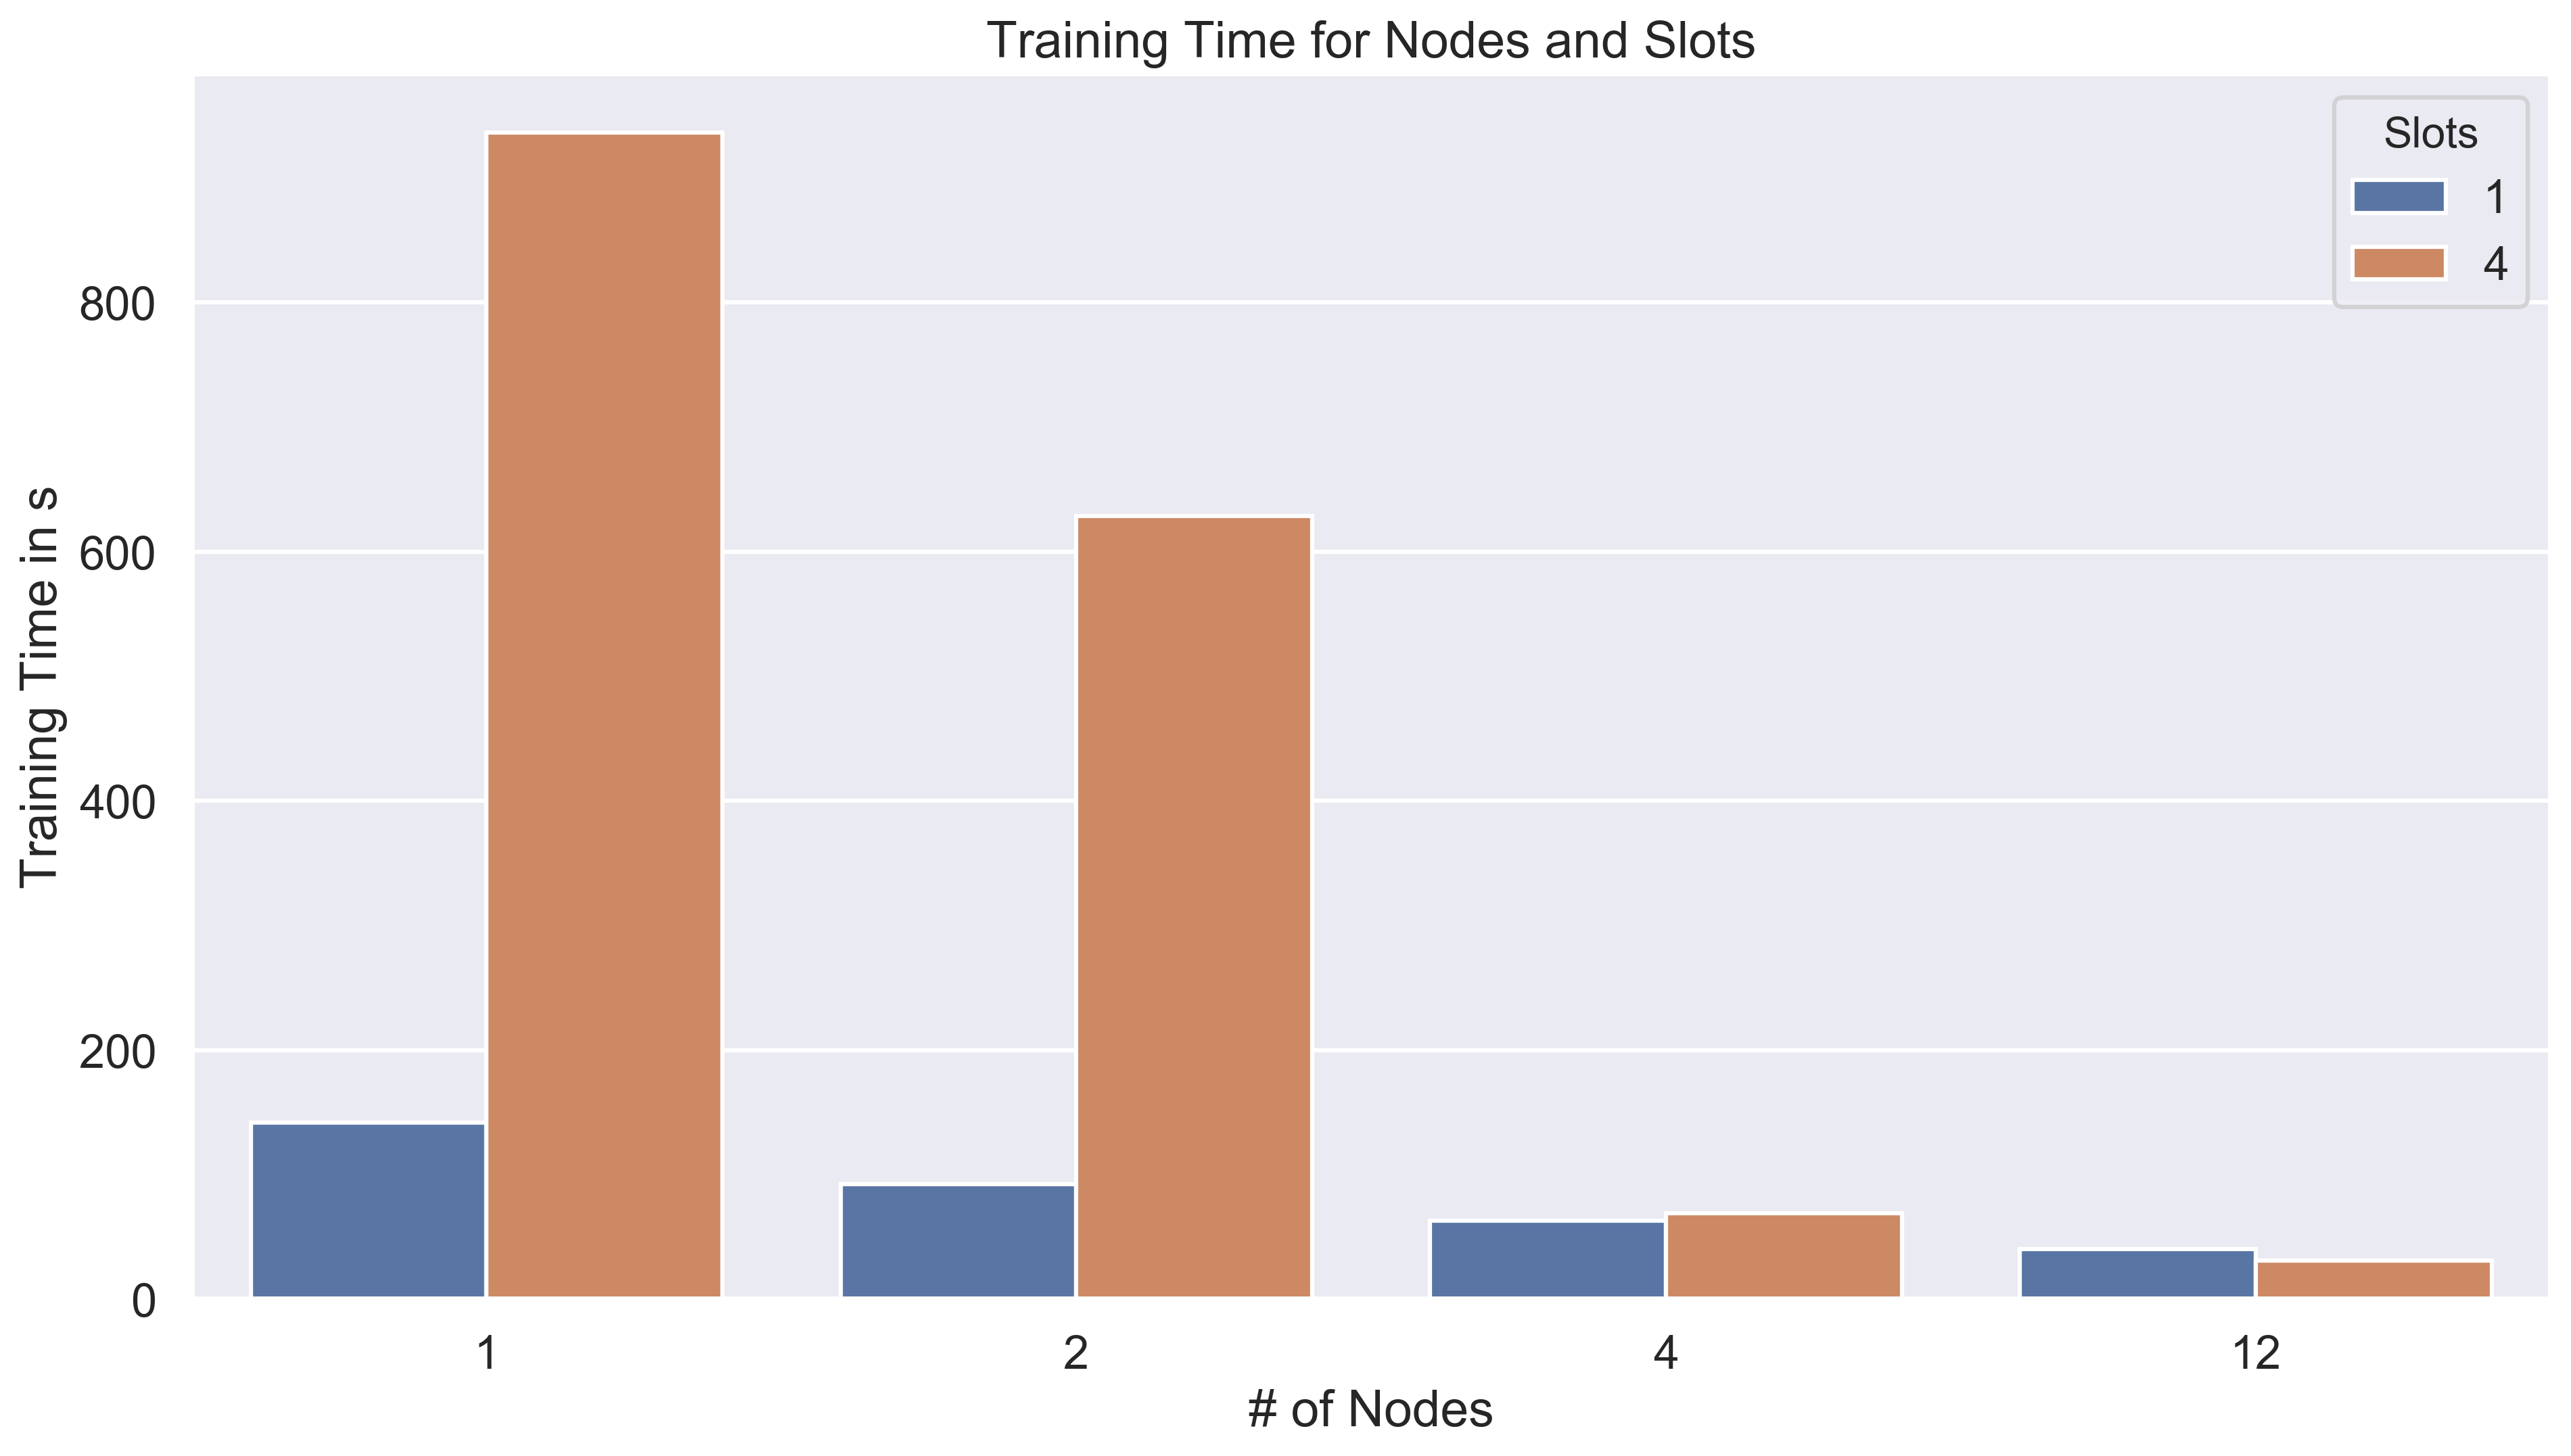

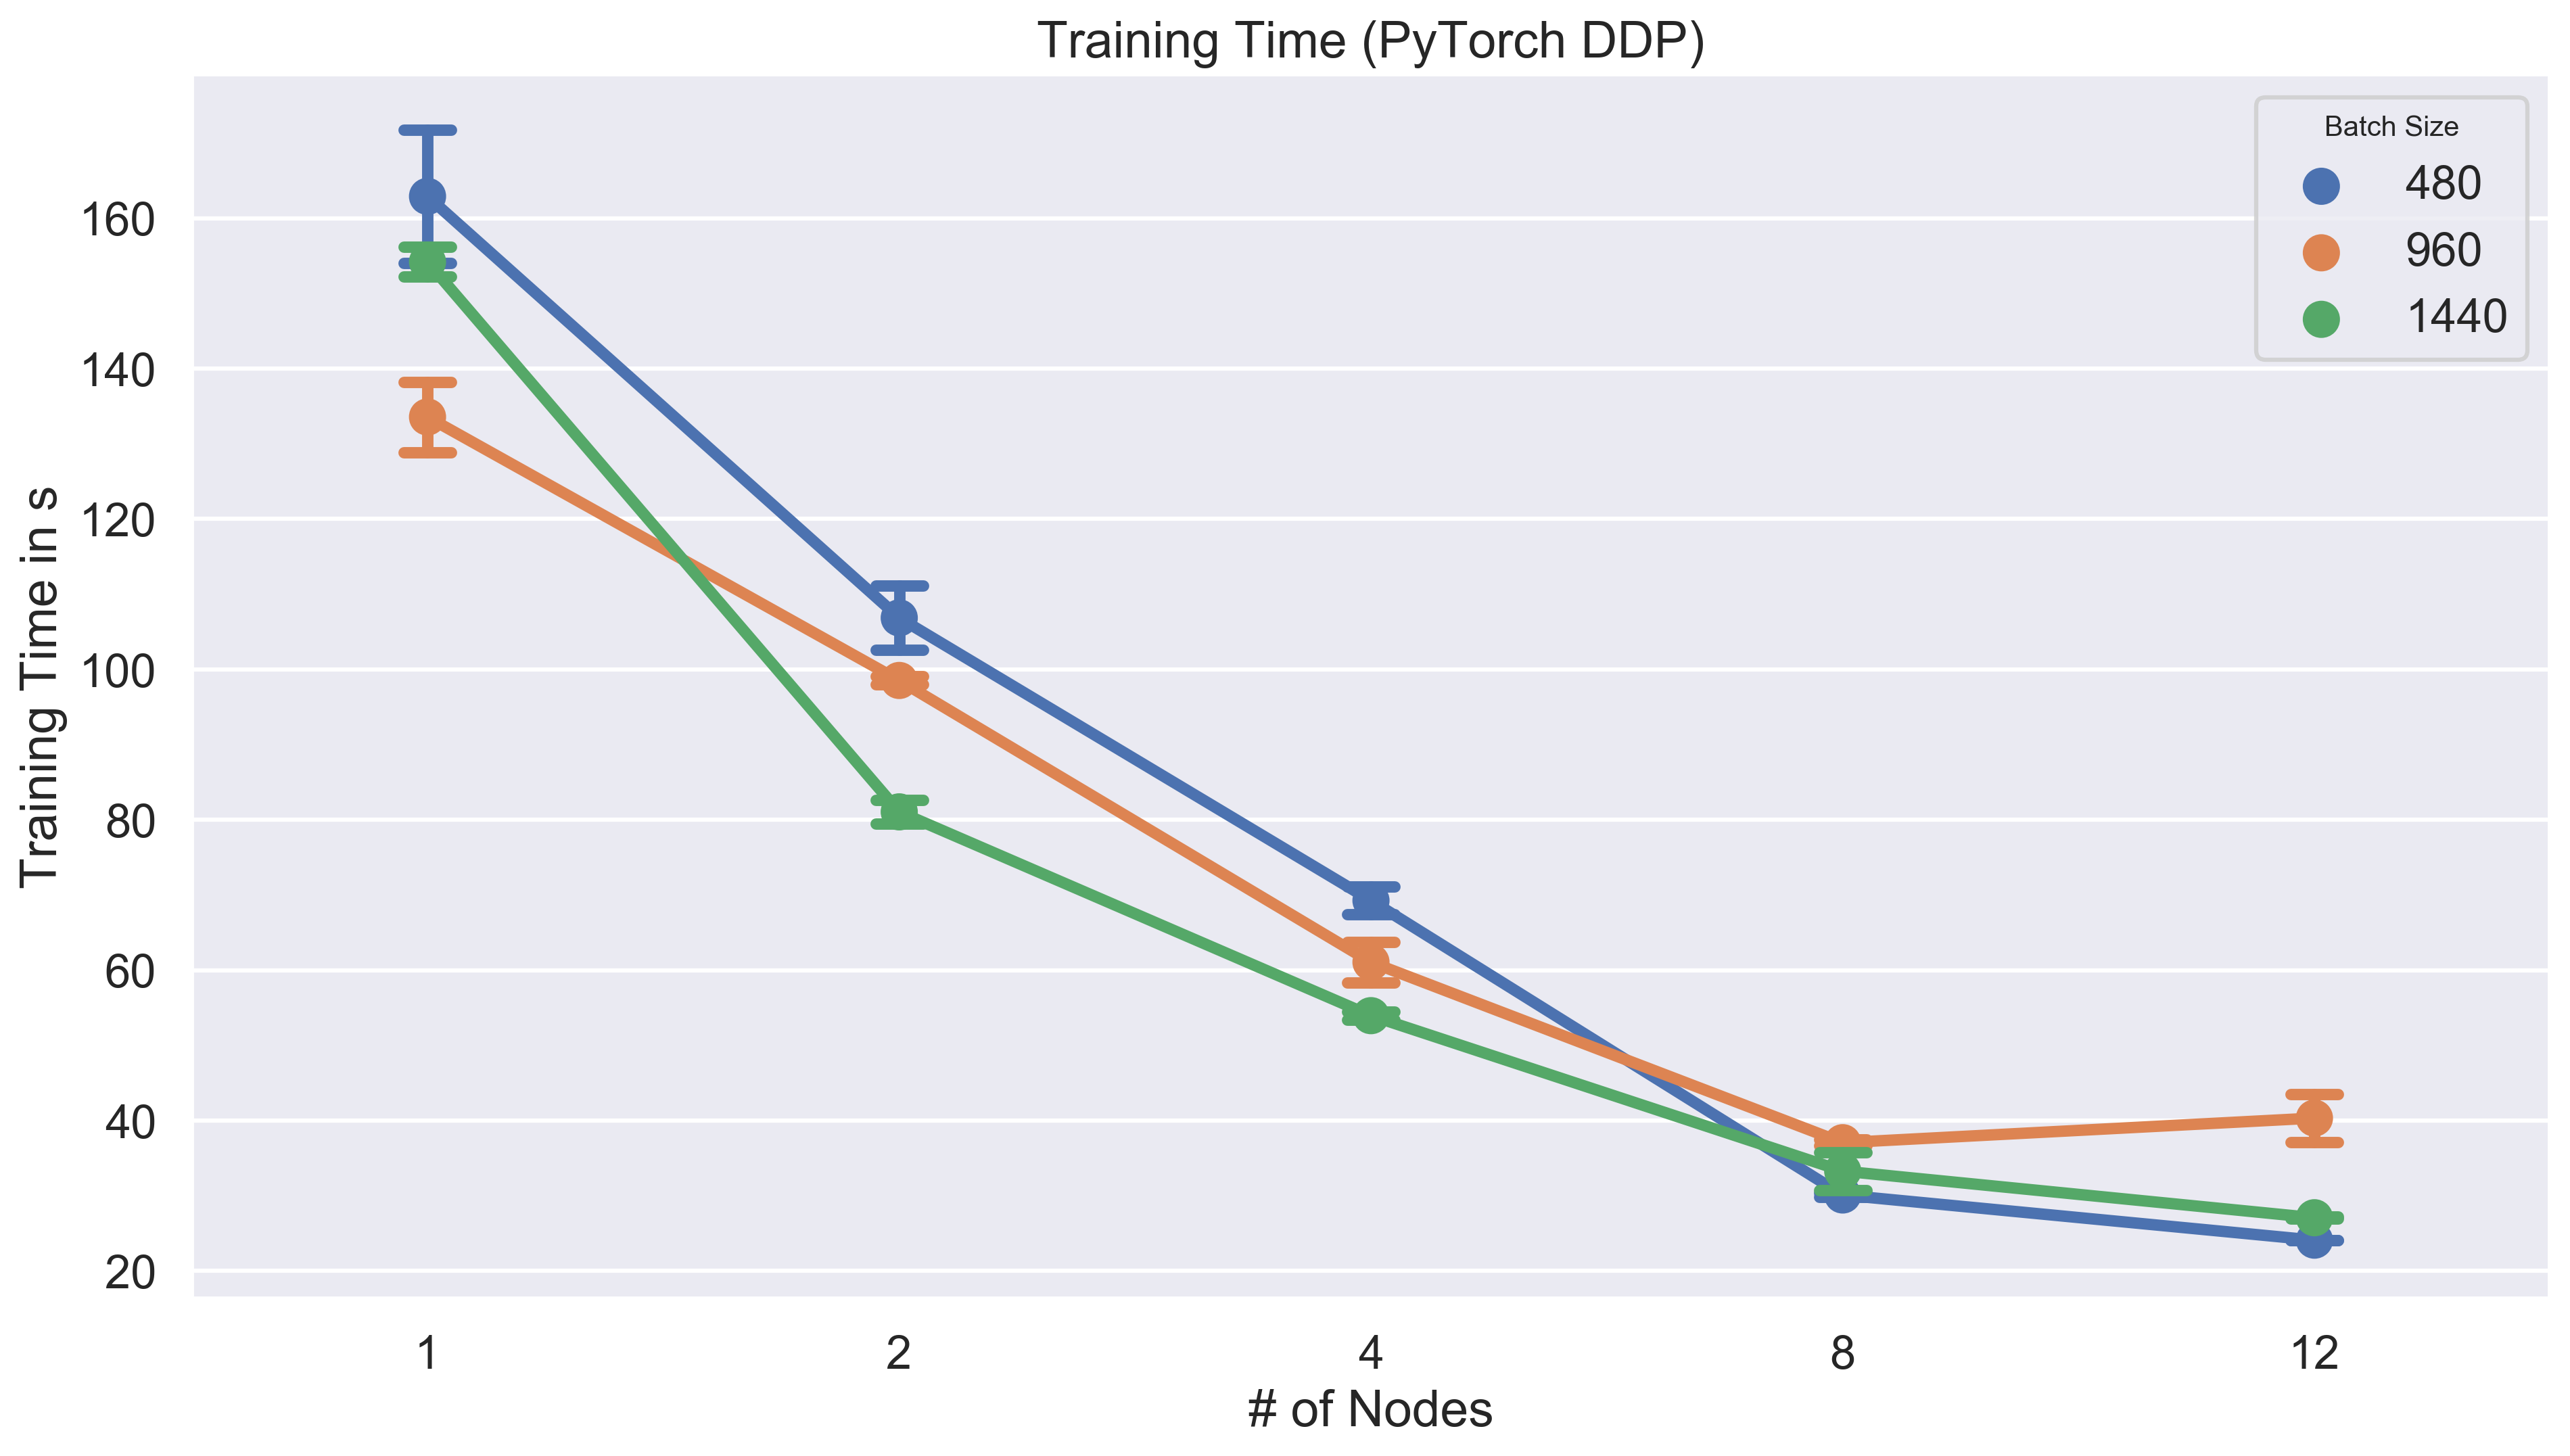

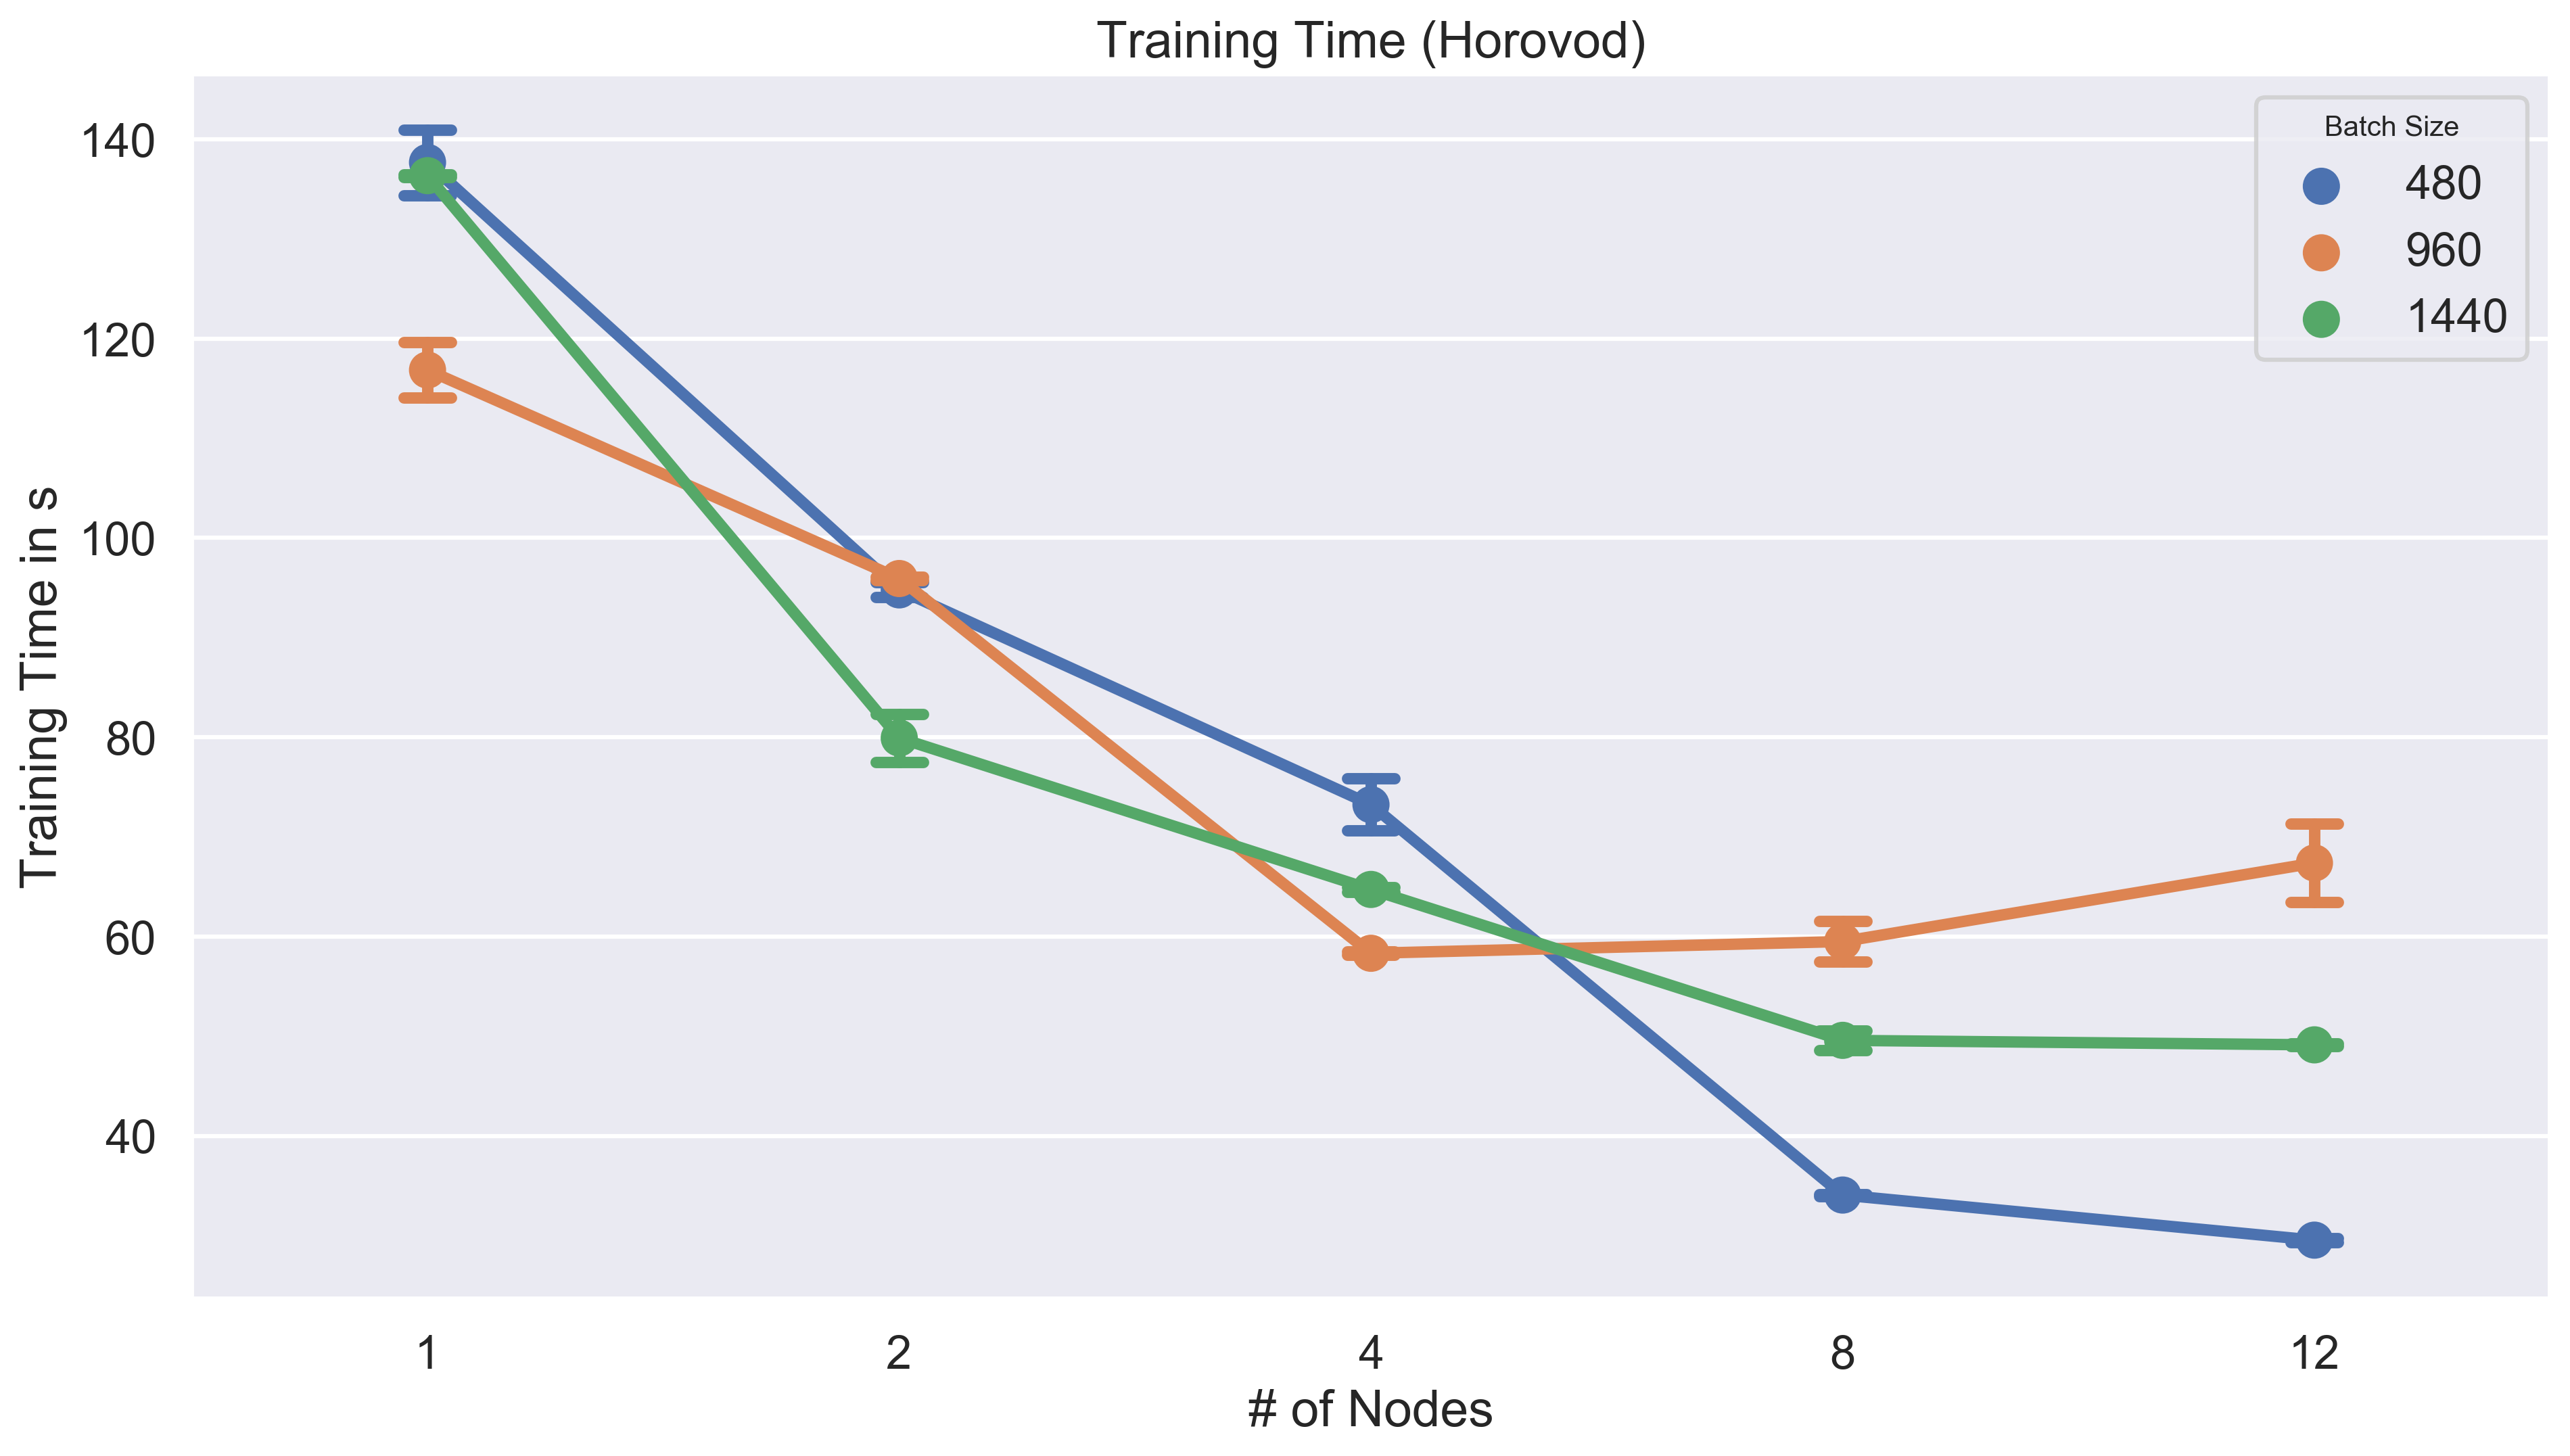

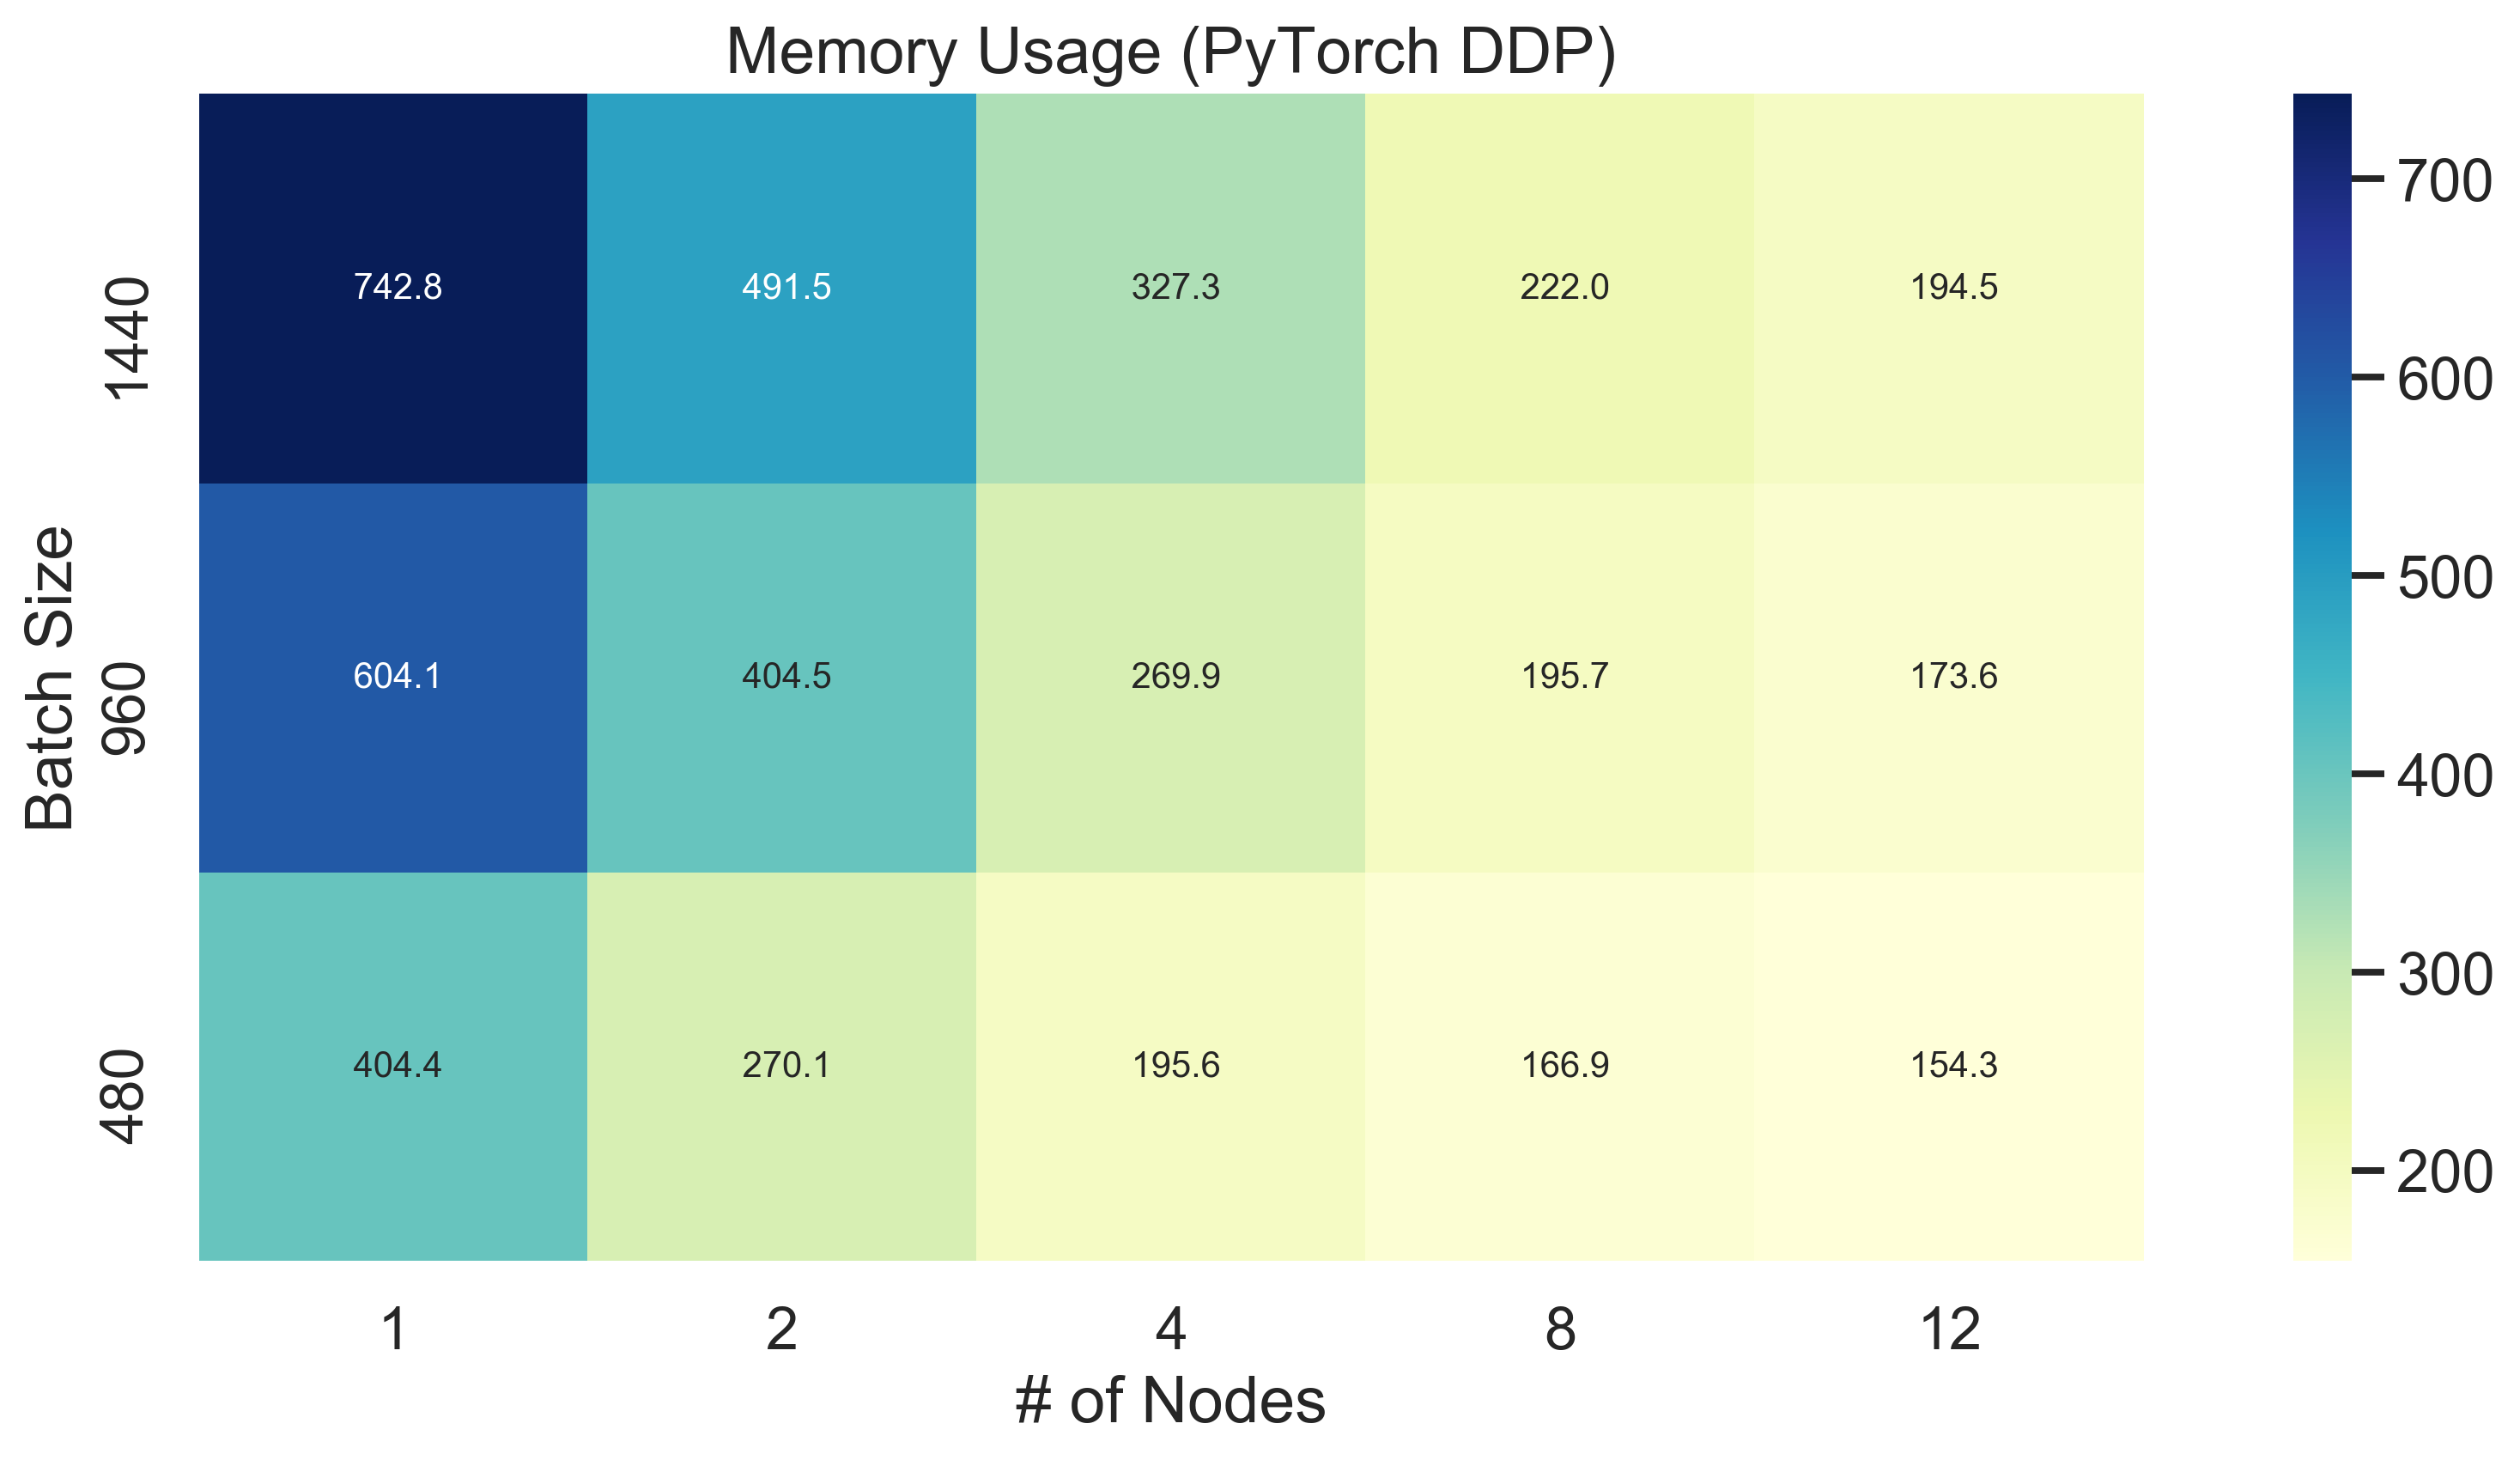

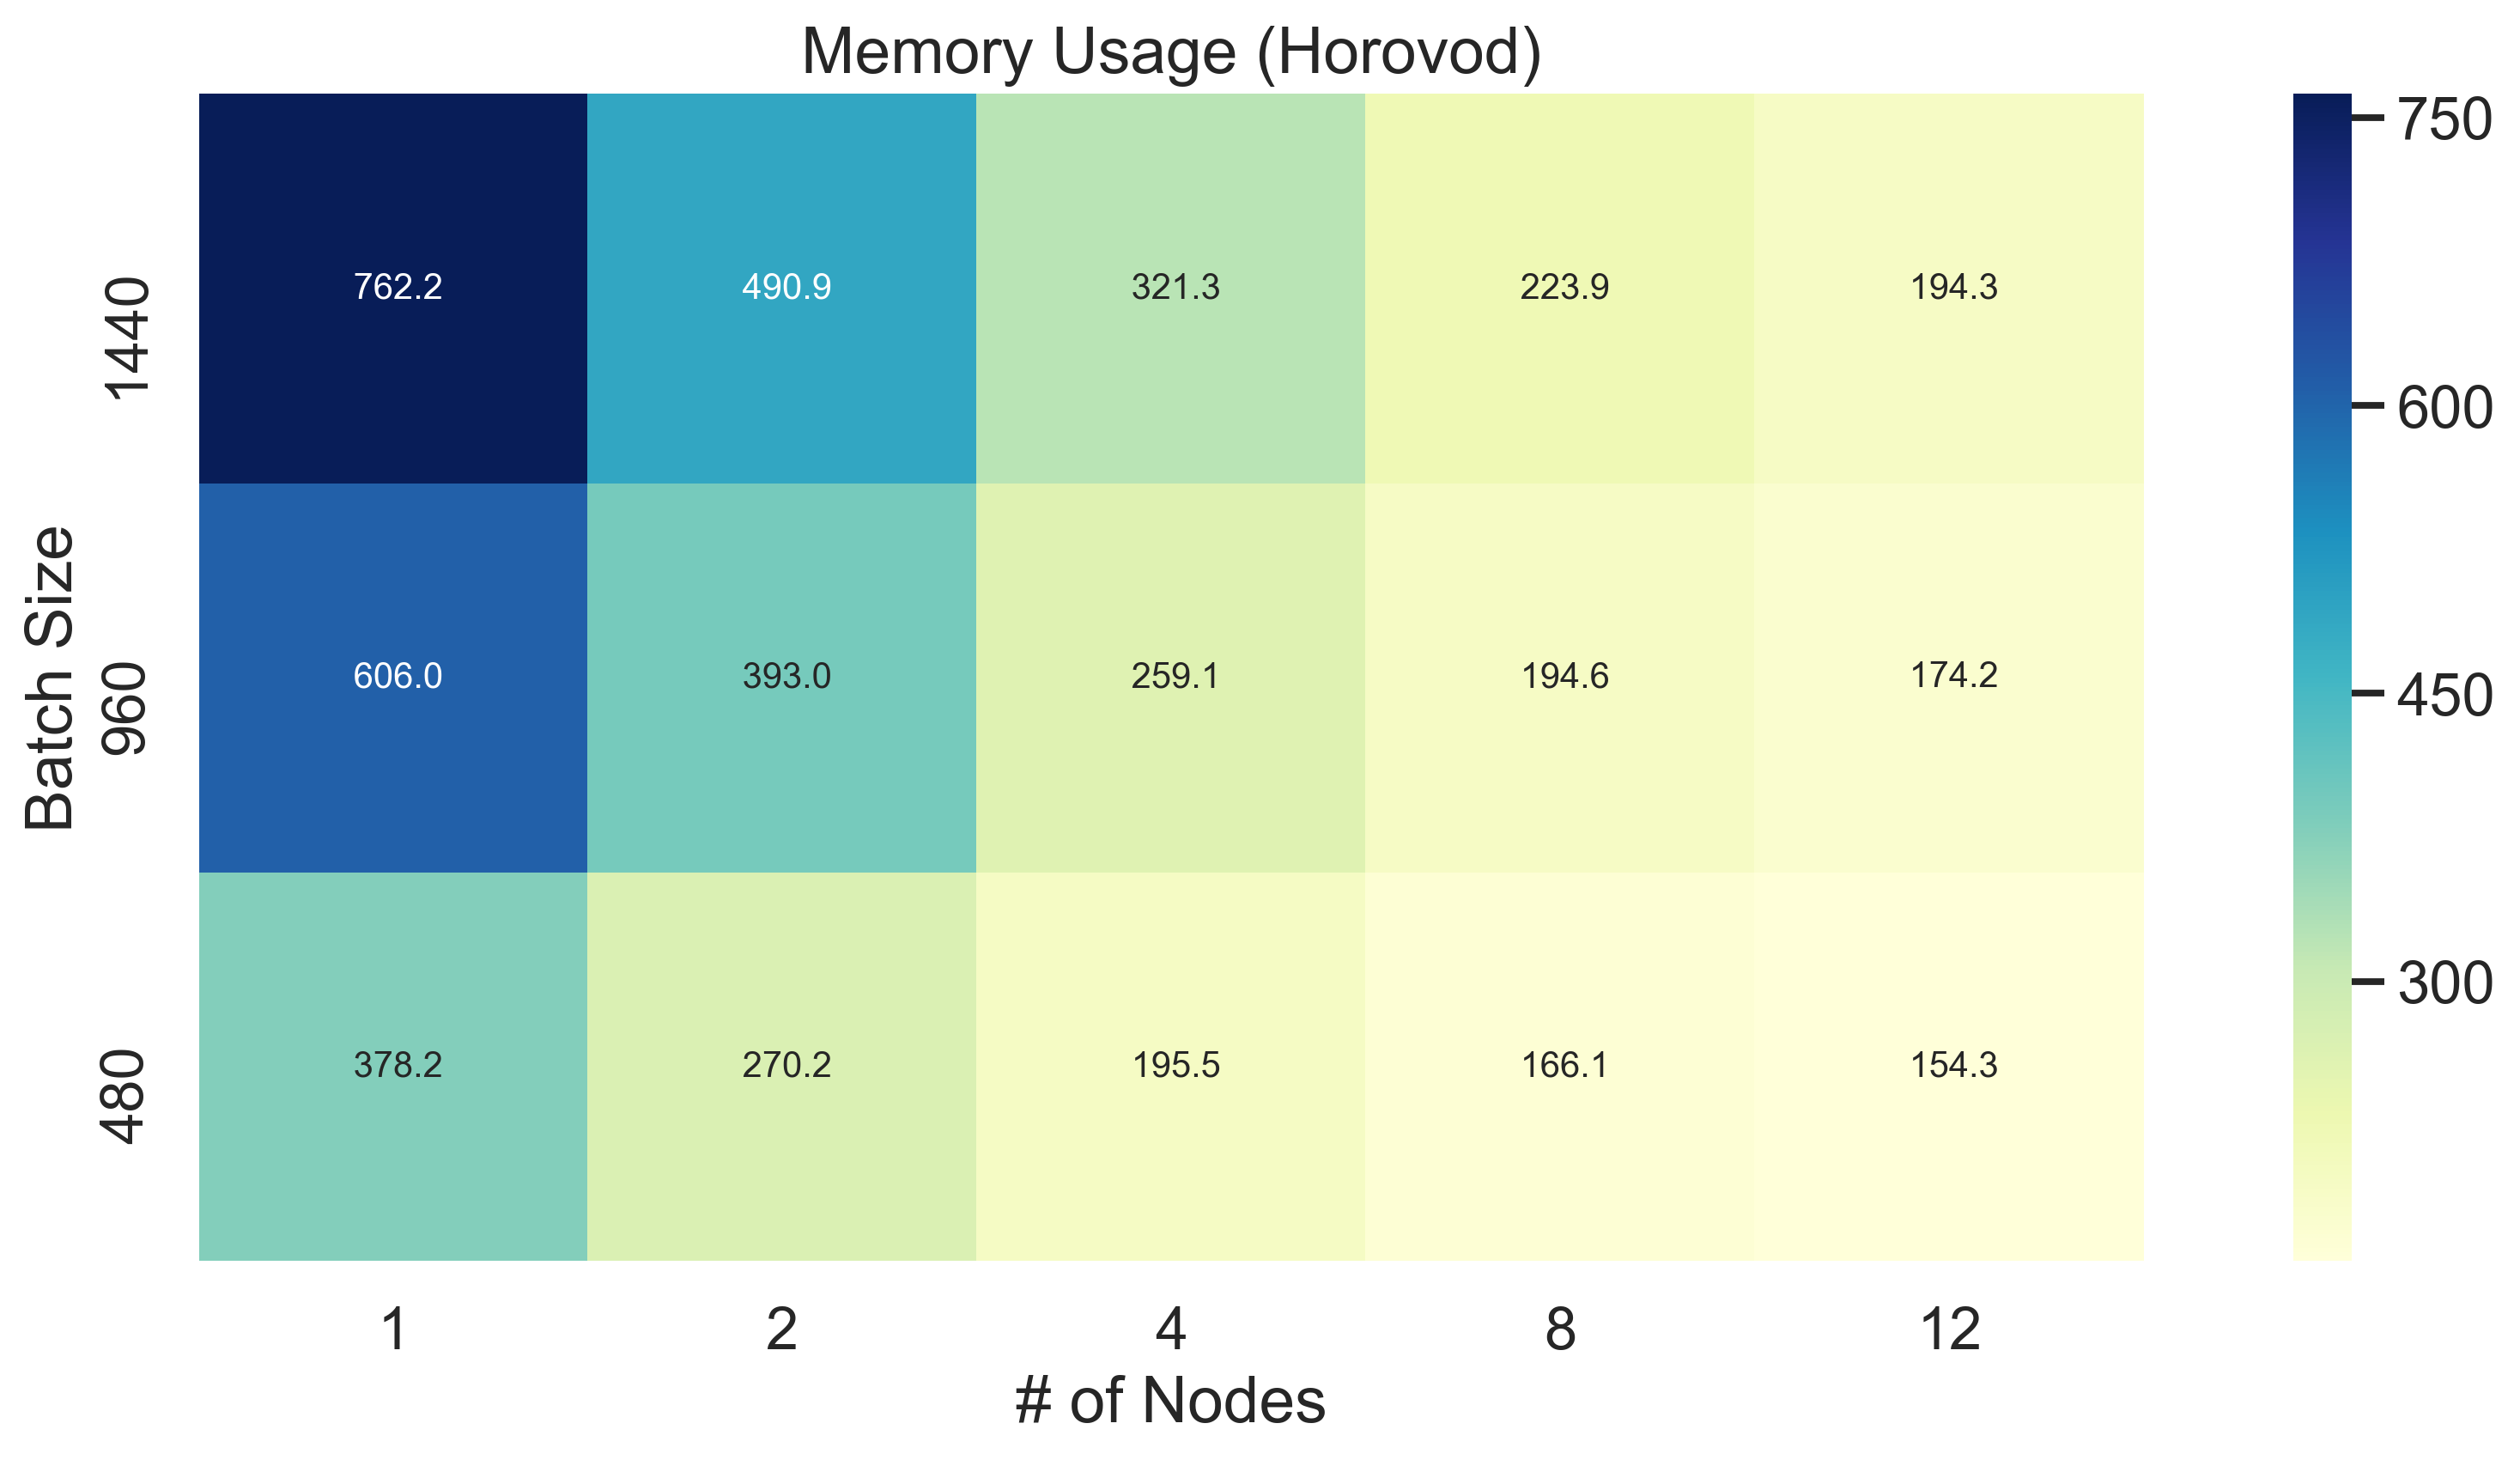

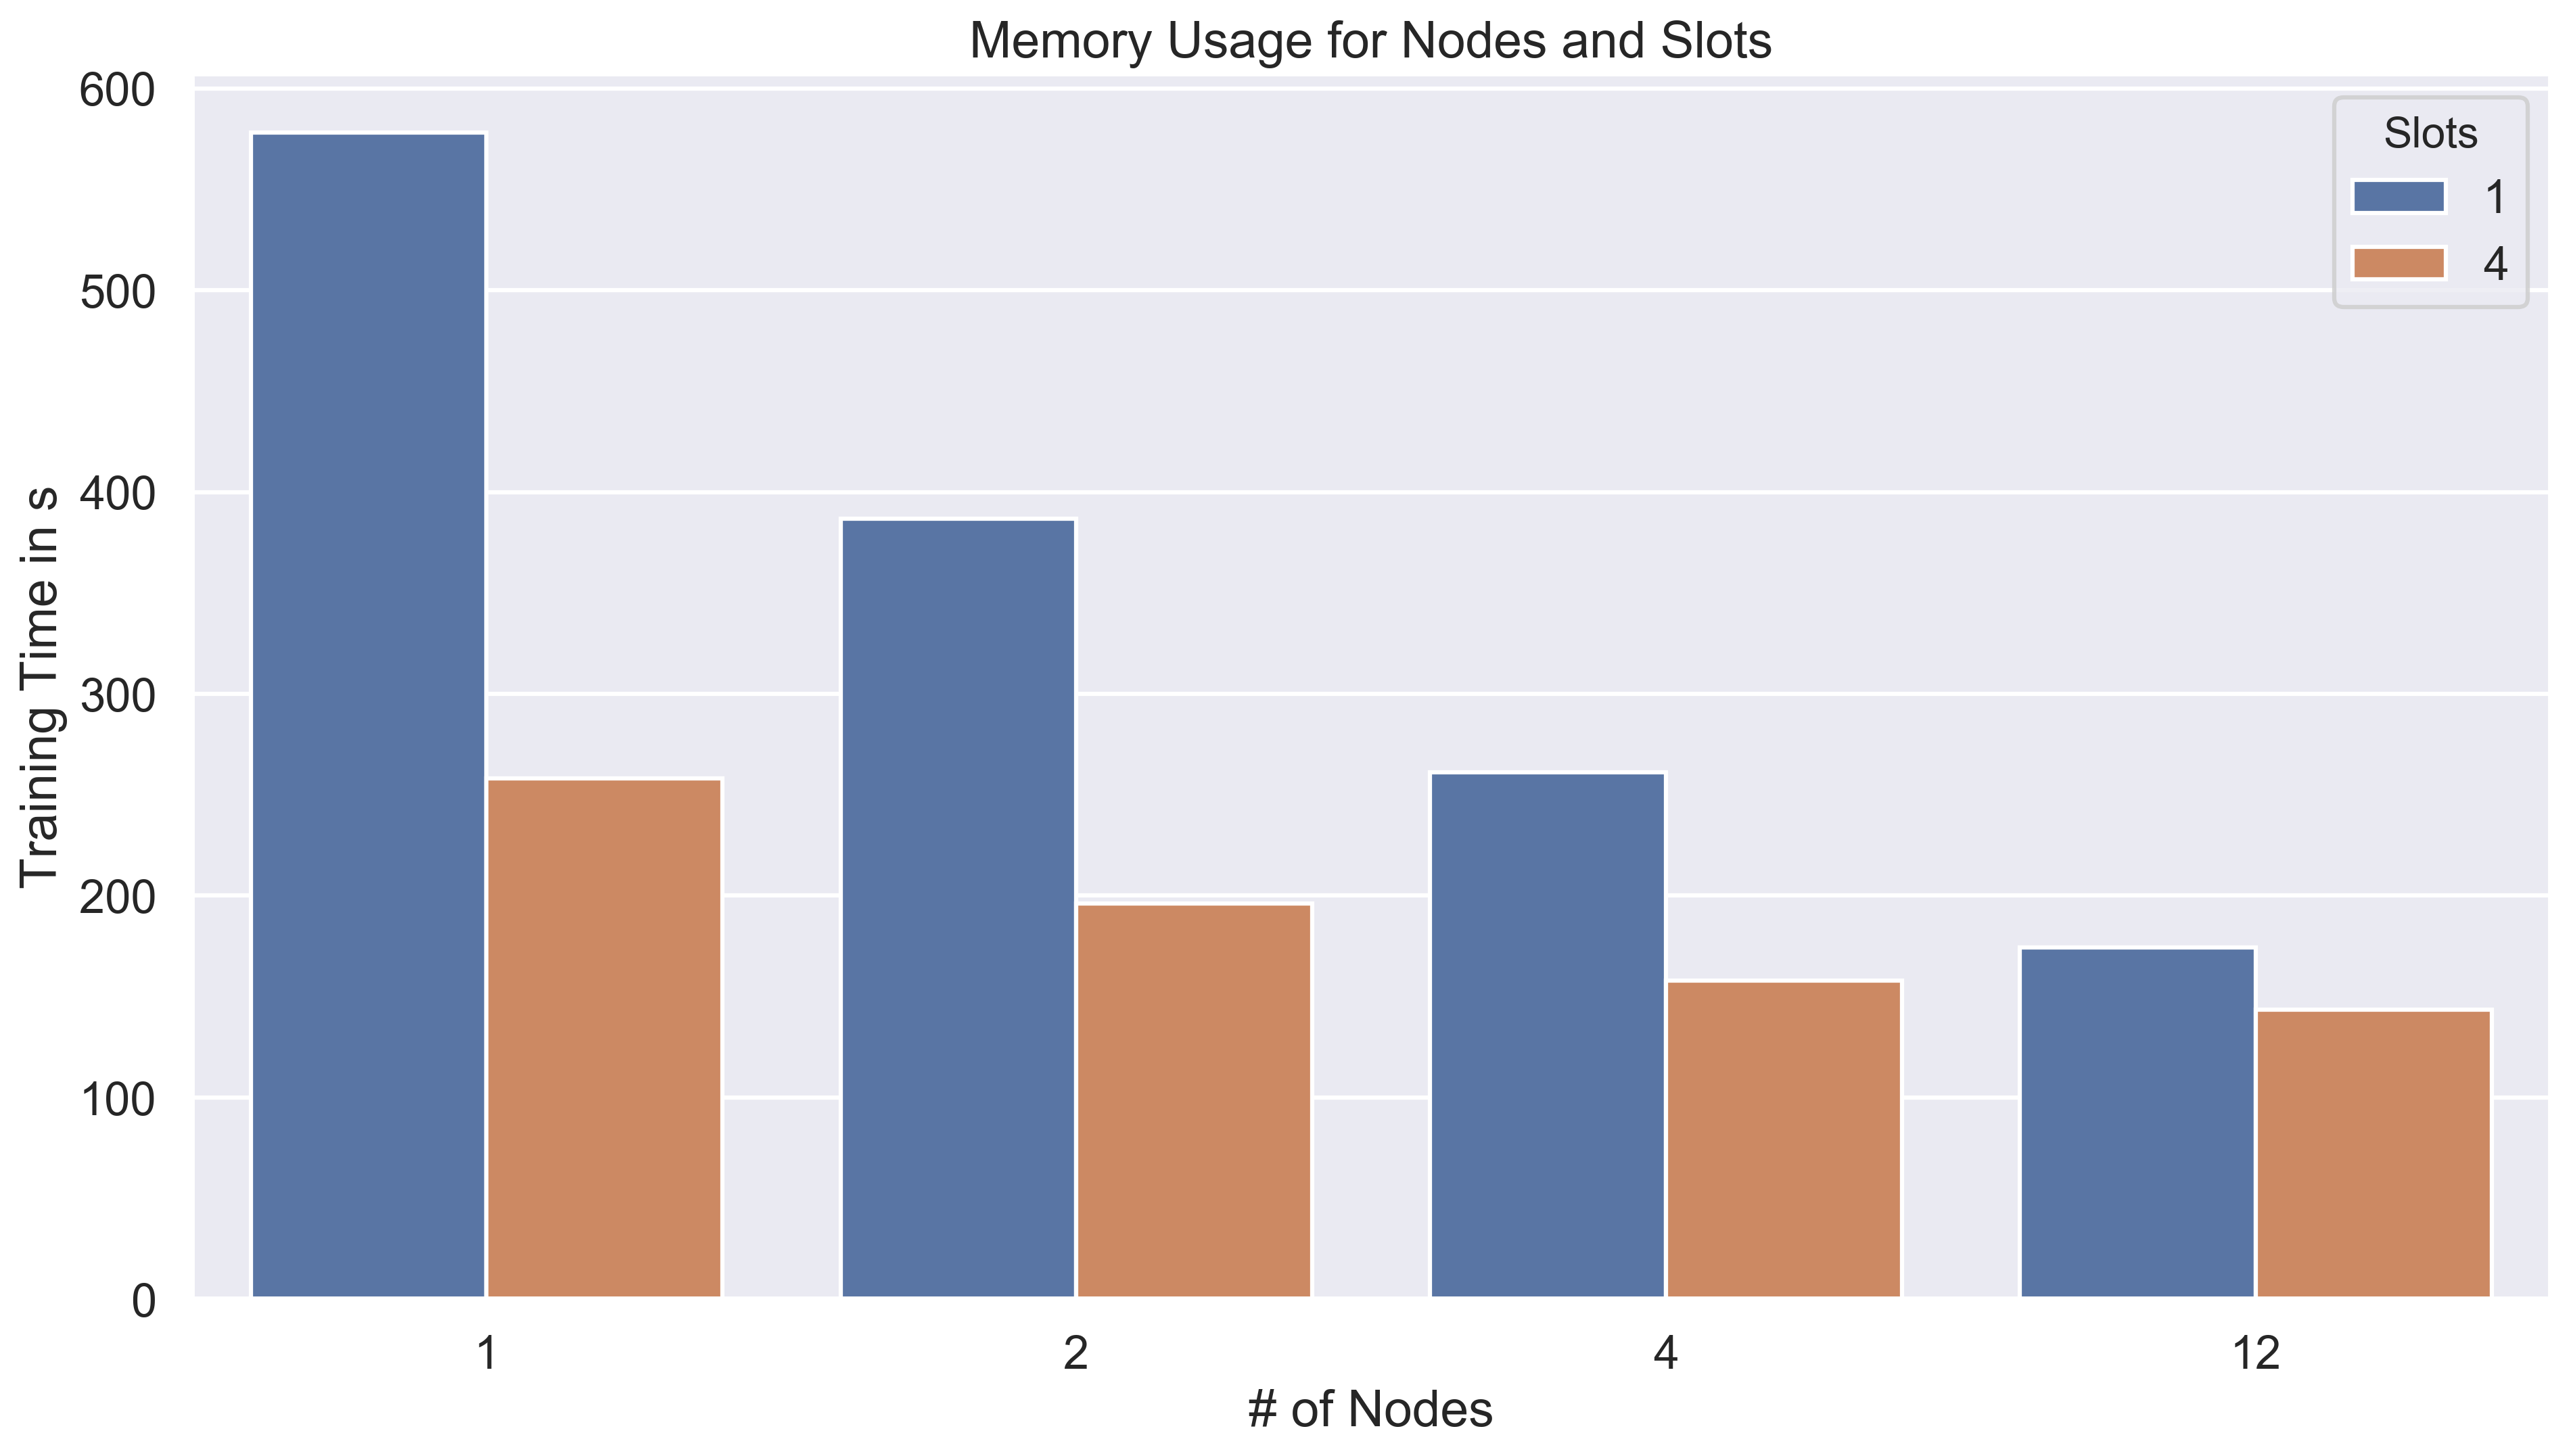

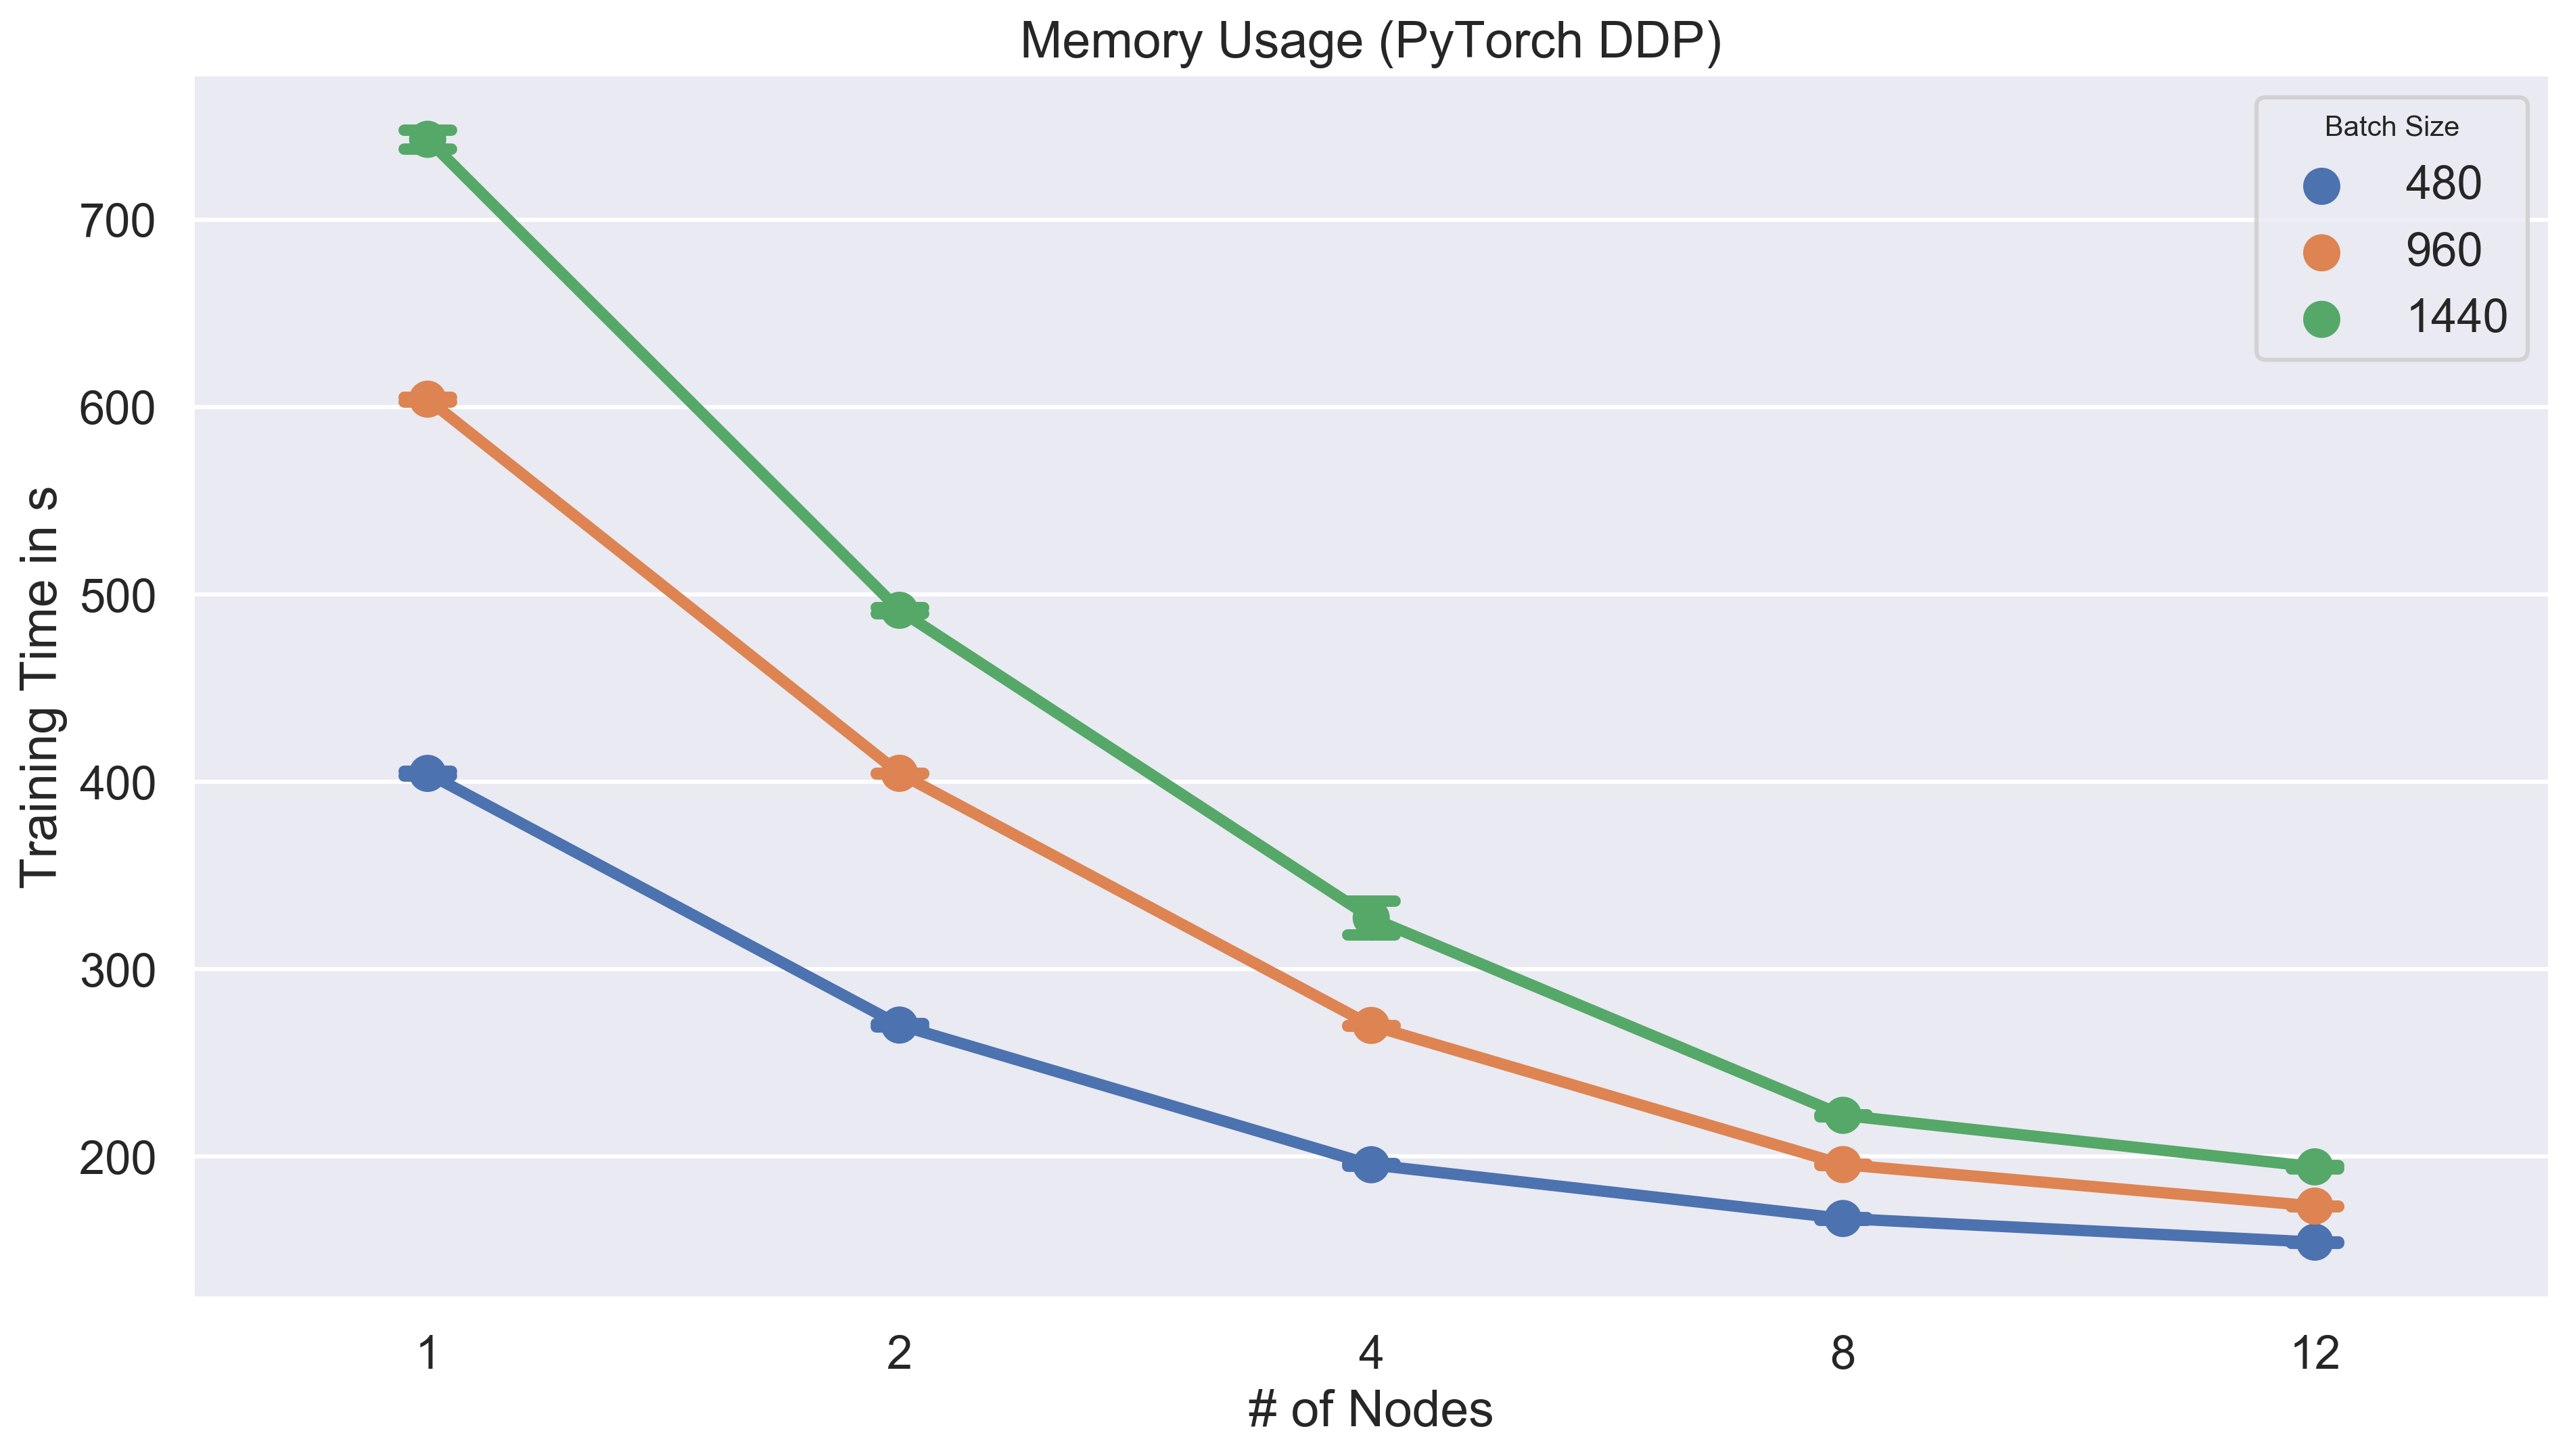

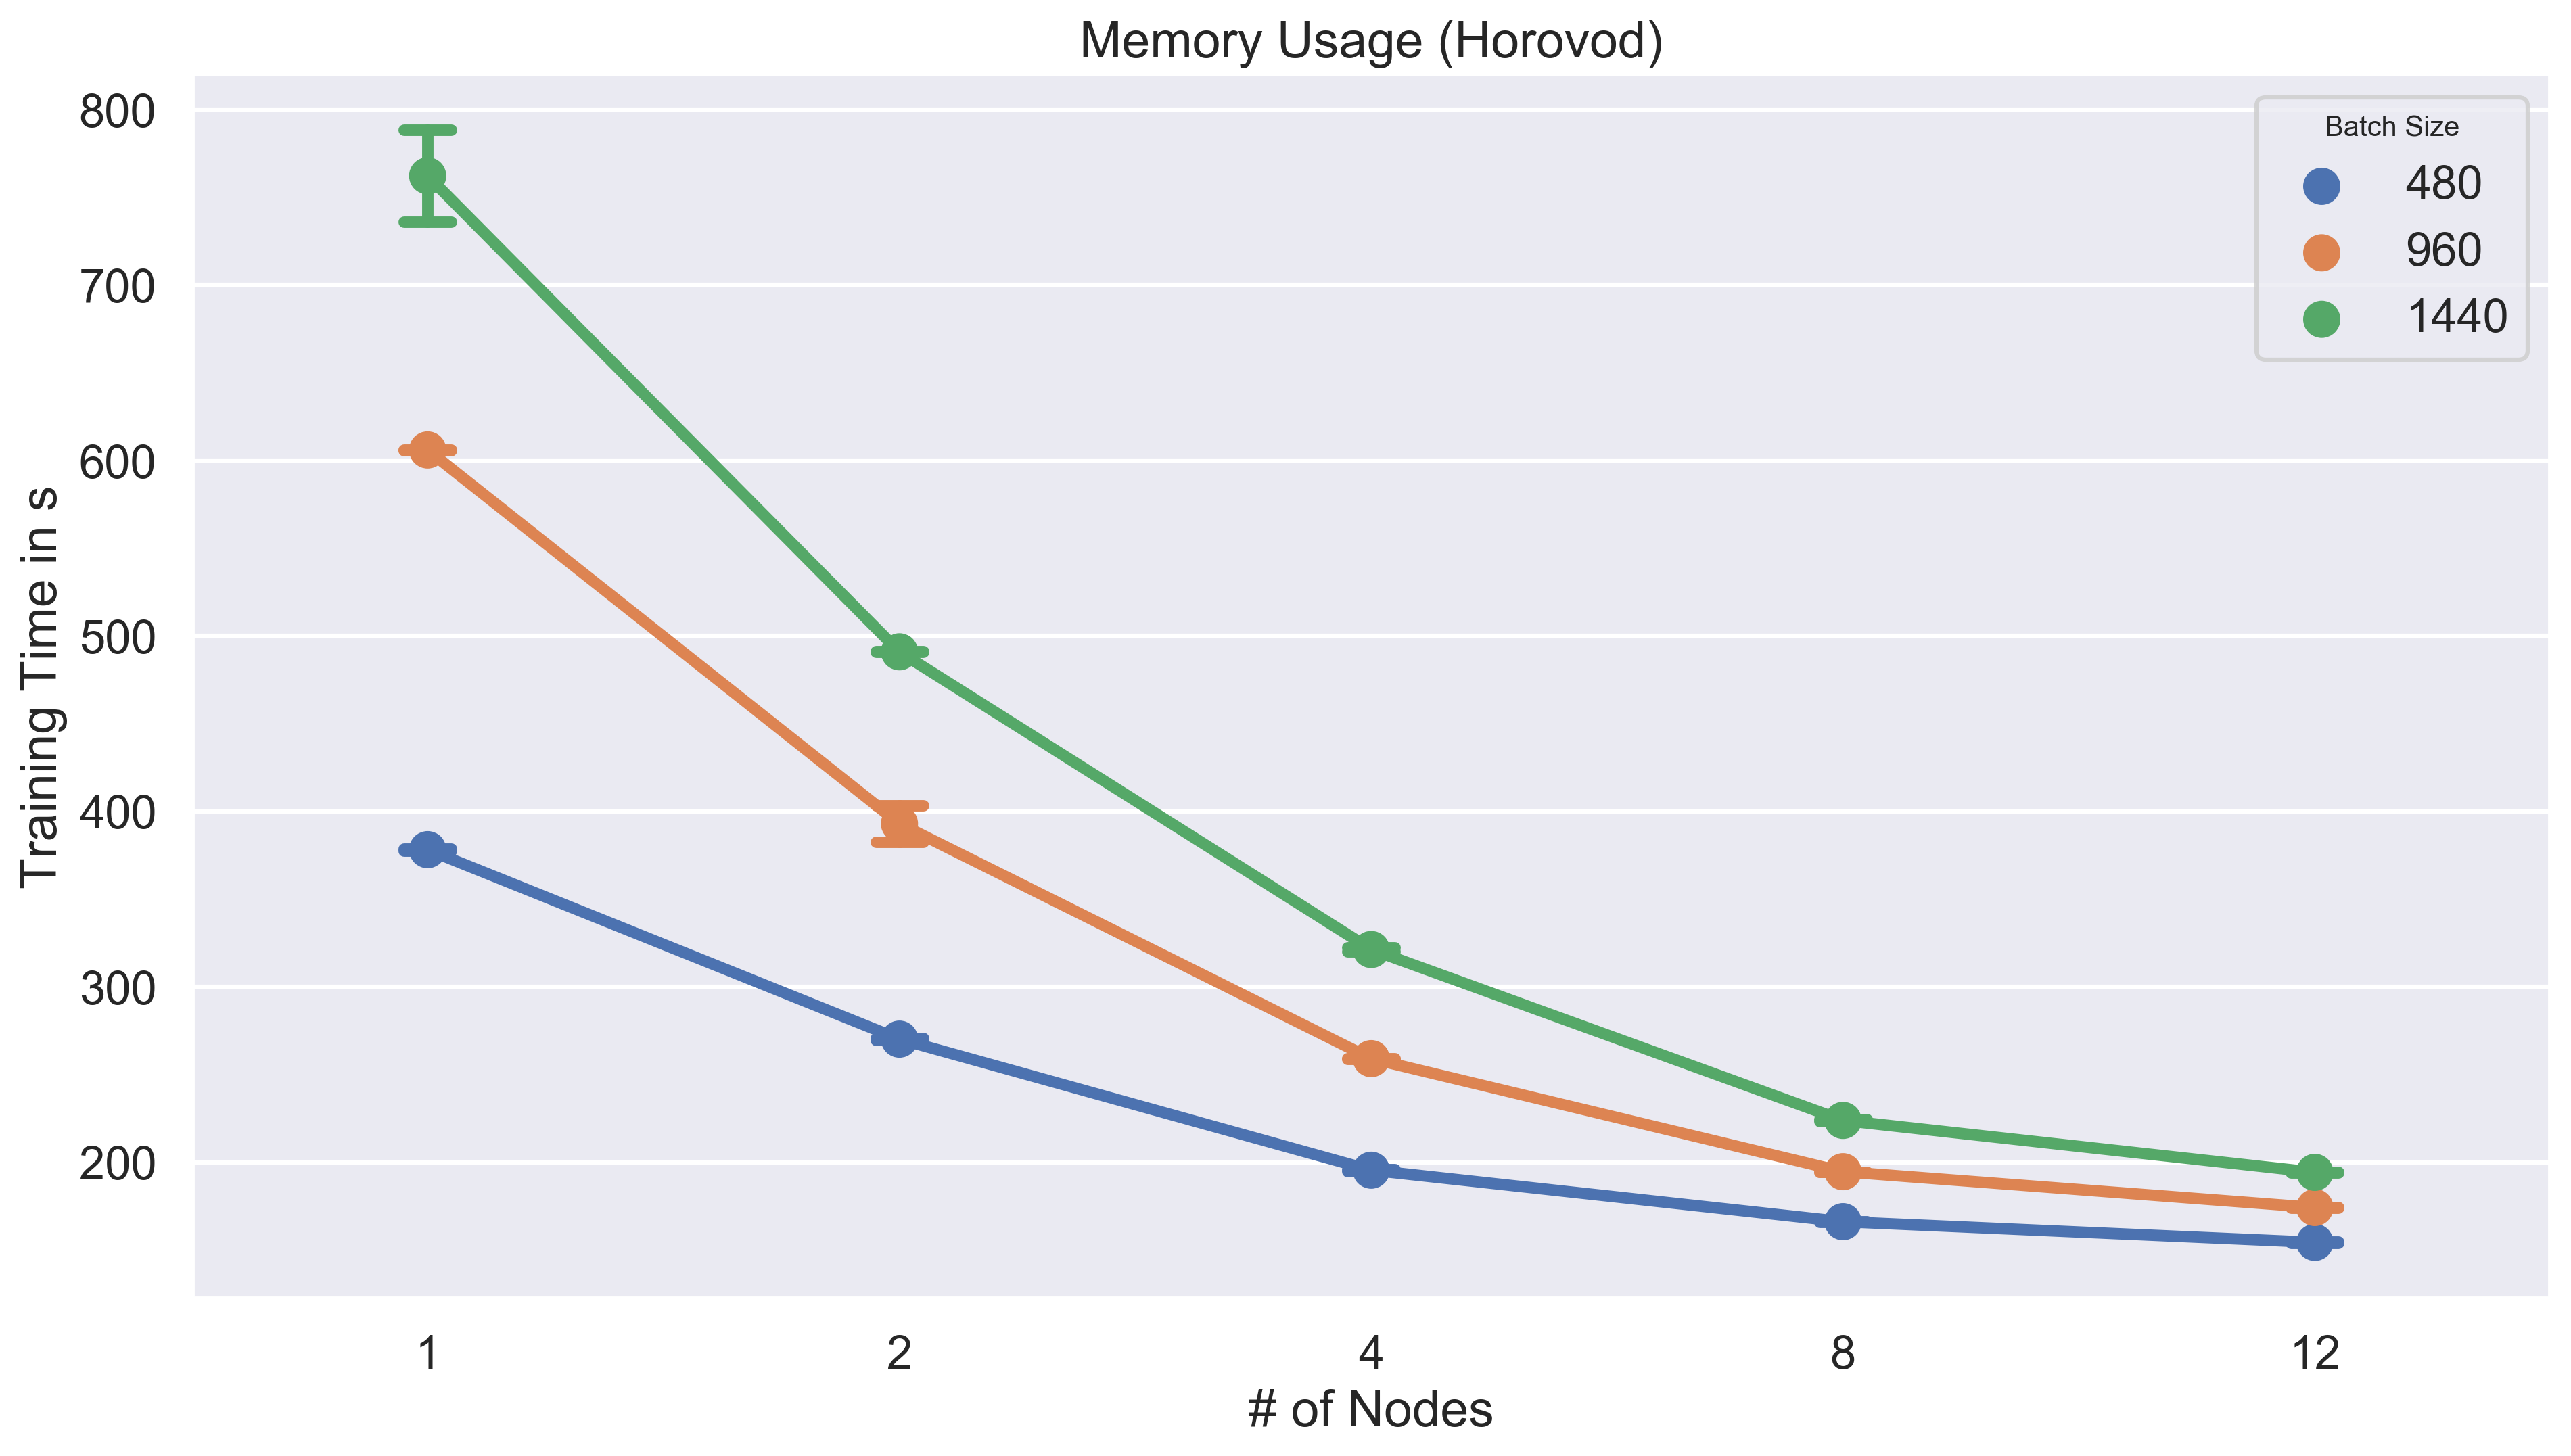

In [61]:
df1 = create_measurement_df('results_ranks.json')
df2 = create_measurement_df('results_202007141530.json')
df3 = create_measurement_df('results_202007141730.json')
df0 = pd.concat((df1, df2, df3))
for measurement in ["Training Time", "Memory Usage"]:
    create_heatmap(df0, measurement)
    create_slot_bar_chart(df0, measurement)
    create_point_plot(df0, measurement)

In [22]:
df = df0[df0["Slots"] == 1].drop("Slots", axis=1)
df

,Trainer,Nodes,Batches,Training Time,Memory Usage
0,Distributed,8,1440,35.080885,221.554688
2,Distributed,8,480,29.919396,166.476562
4,Horovod,4,960,58.427846,258.867188
6,Horovod,2,480,94.263650,269.679688
7,Distributed,2,1440,82.197478,490.351562
...,...,...,...,...,...
28,Local,1,960,130.745825,603.488281
29,Local,1,1440,148.894556,729.734375
30,Horovod,1,960,120.775297,605.777344
31,Distributed,8,1440,29.716609,222.812500


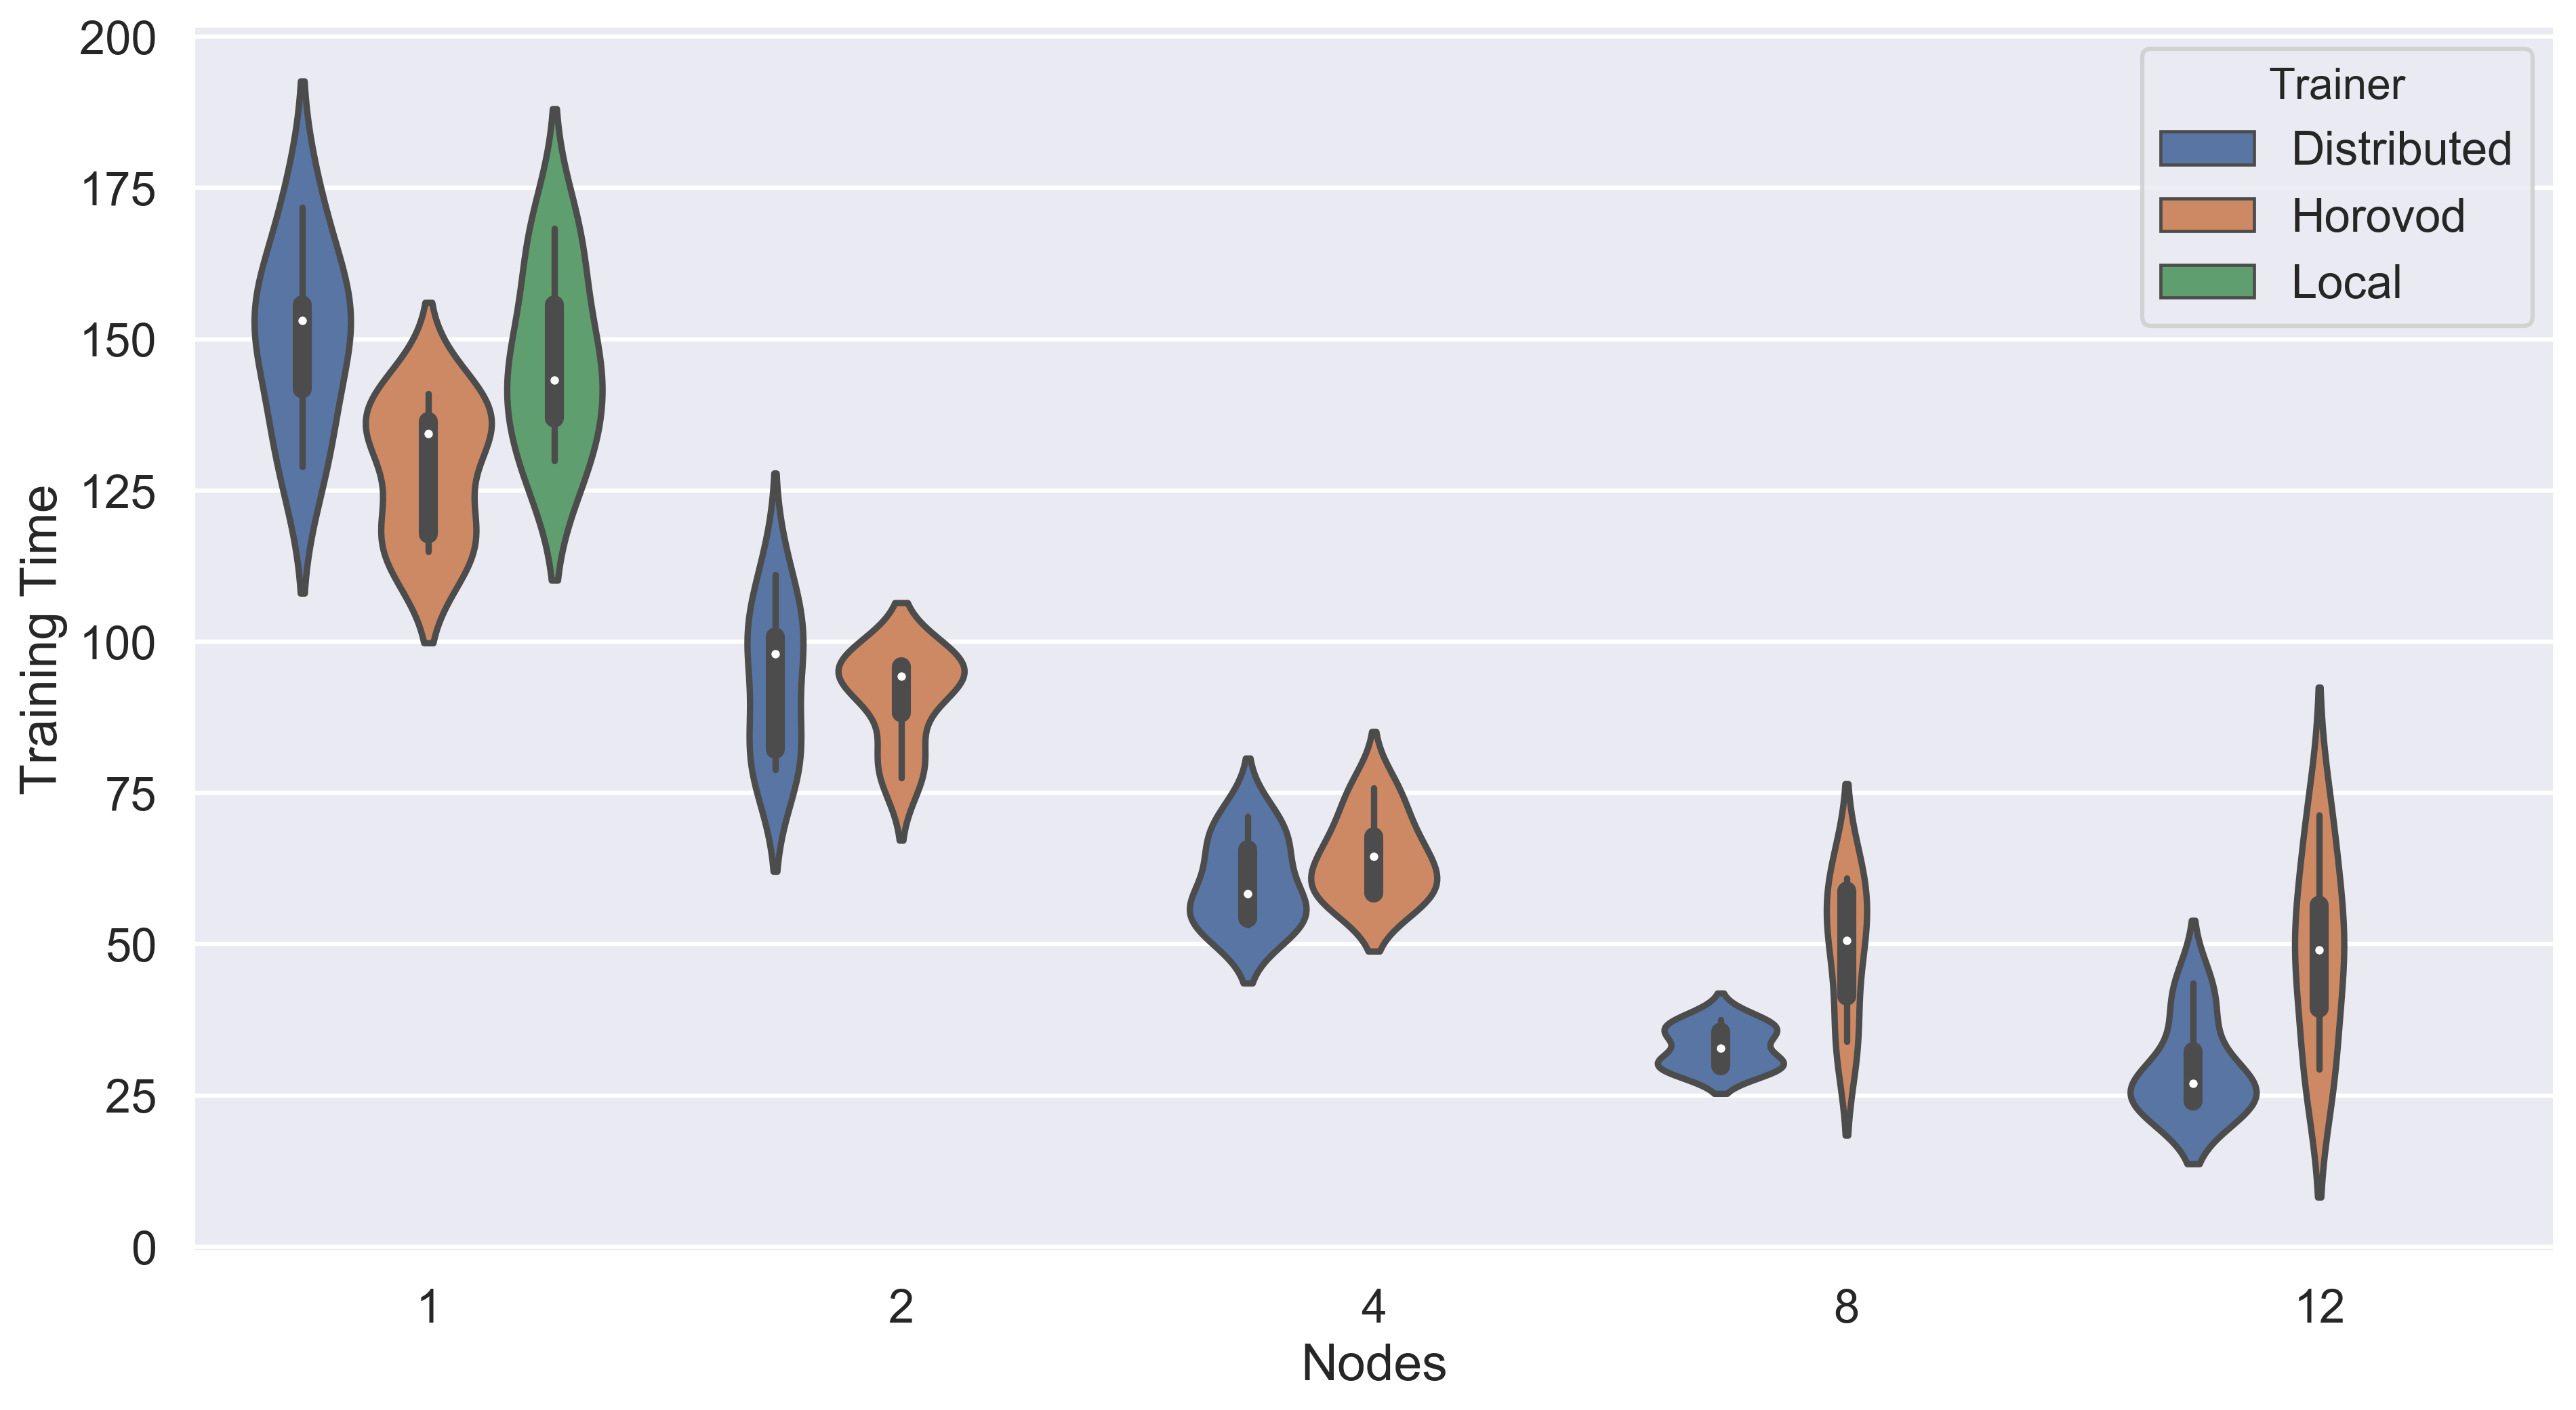

In [368]:
fig = plt.figure(figsize=(15, 8), dpi= 300)
sns.violinplot(x="Nodes", y="Training Time", hue="Trainer", data=df)

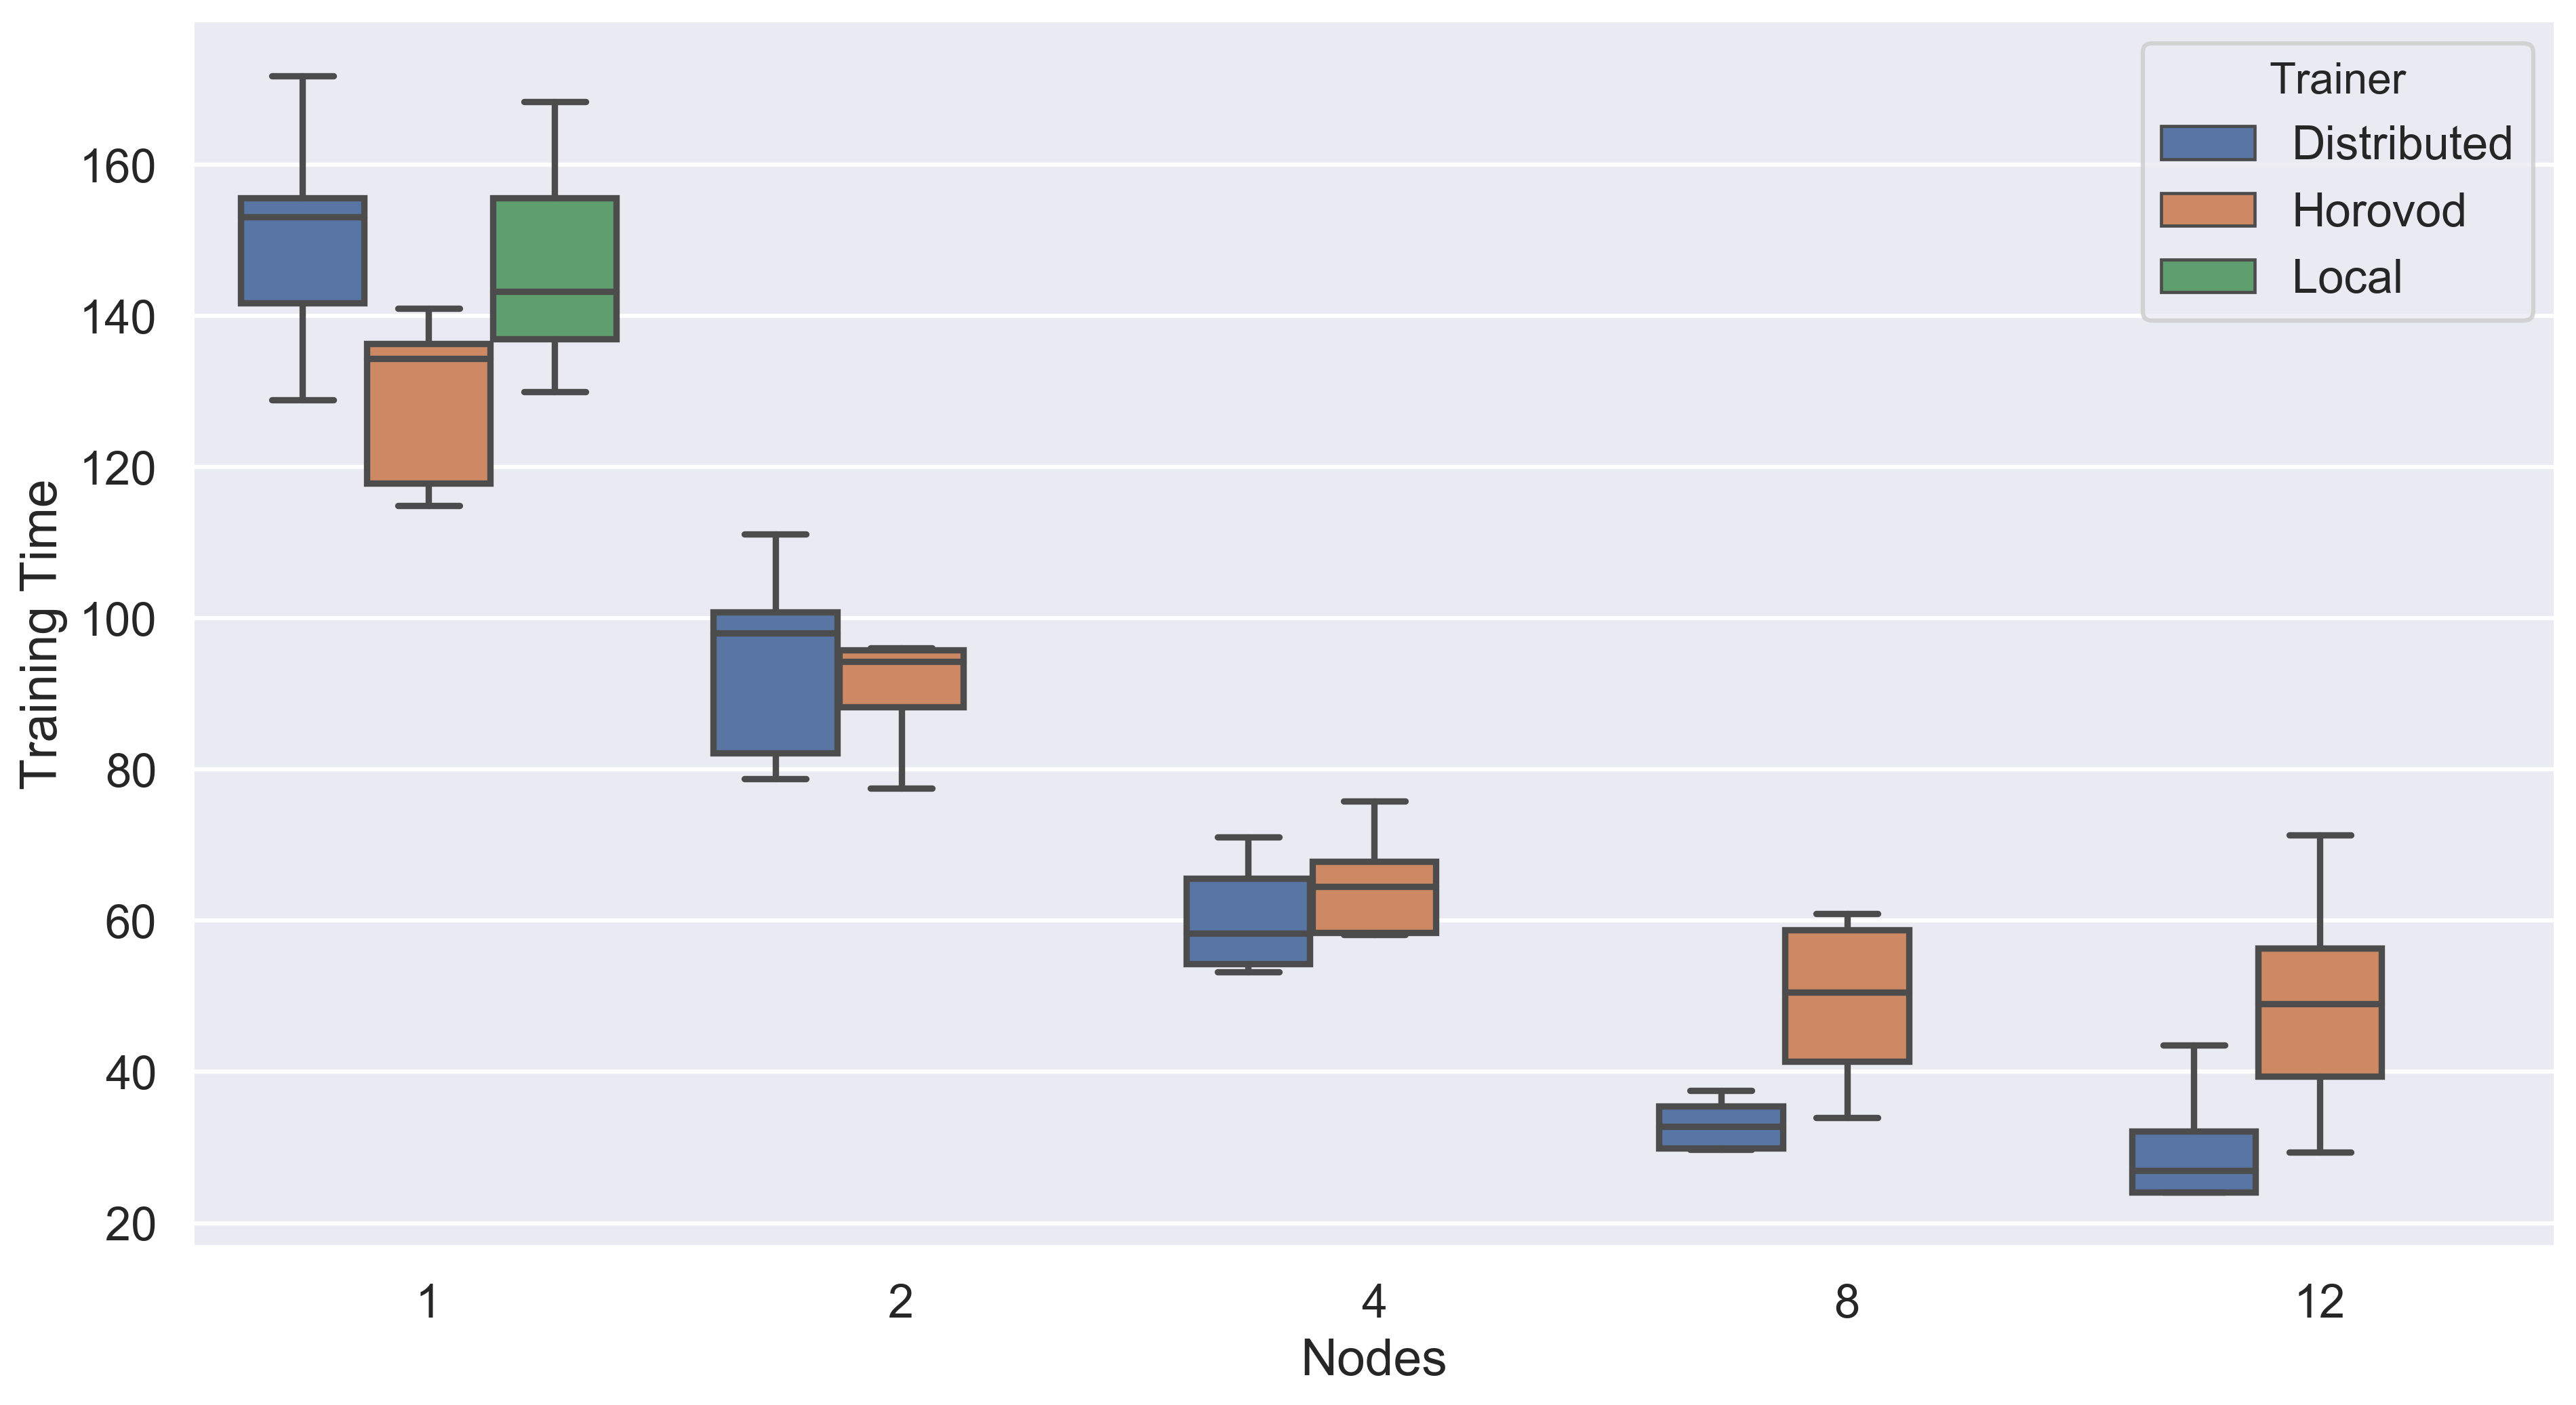

In [369]:
fig = plt.figure(figsize=(15, 8), dpi= 300)
sns.boxplot(x="Nodes", y="Training Time", hue="Trainer", data=df)

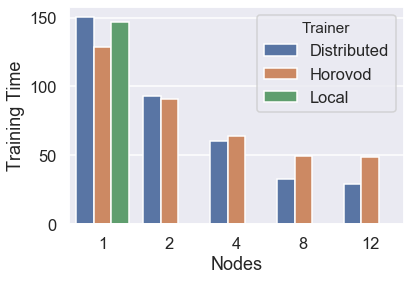

In [15]:
sns.barplot(x="Nodes", y="Training Time", hue="Trainer", data=df.drop("Batches", axis=1).groupby(["Nodes", "Trainer"]).mean().reset_index())

In [16]:
df

,Trainer,Nodes,Batches,Training Time,Memory Usage
0,Distributed,8,1440,35.080885,221.554688
2,Distributed,8,480,29.919396,166.476562
4,Horovod,4,960,58.427846,258.867188
6,Horovod,2,480,94.263650,269.679688
7,Distributed,2,1440,82.197478,490.351562
...,...,...,...,...,...
28,Local,1,960,130.745825,603.488281
29,Local,1,1440,148.894556,729.734375
30,Horovod,1,960,120.775297,605.777344
31,Distributed,8,1440,29.716609,222.812500


In [43]:
distributed = df[df["Trainer"] == "Distributed"]
distributed = distributed.drop(["Trainer"], axis=1)

In [44]:
distributed

,Nodes,Batches,Training Time,Memory Usage
0,8,1440,35.080885,221.554688
2,8,480,29.919396,166.476562
7,2,1440,82.197478,490.351562
19,12,480,24.095641,154.105469
20,4,1440,54.327097,320.902344
0,8,1440,35.080885,221.554688
2,8,480,29.919396,166.476562
7,2,1440,82.197478,490.351562
19,12,480,24.095641,154.105469
20,4,1440,54.327097,320.902344


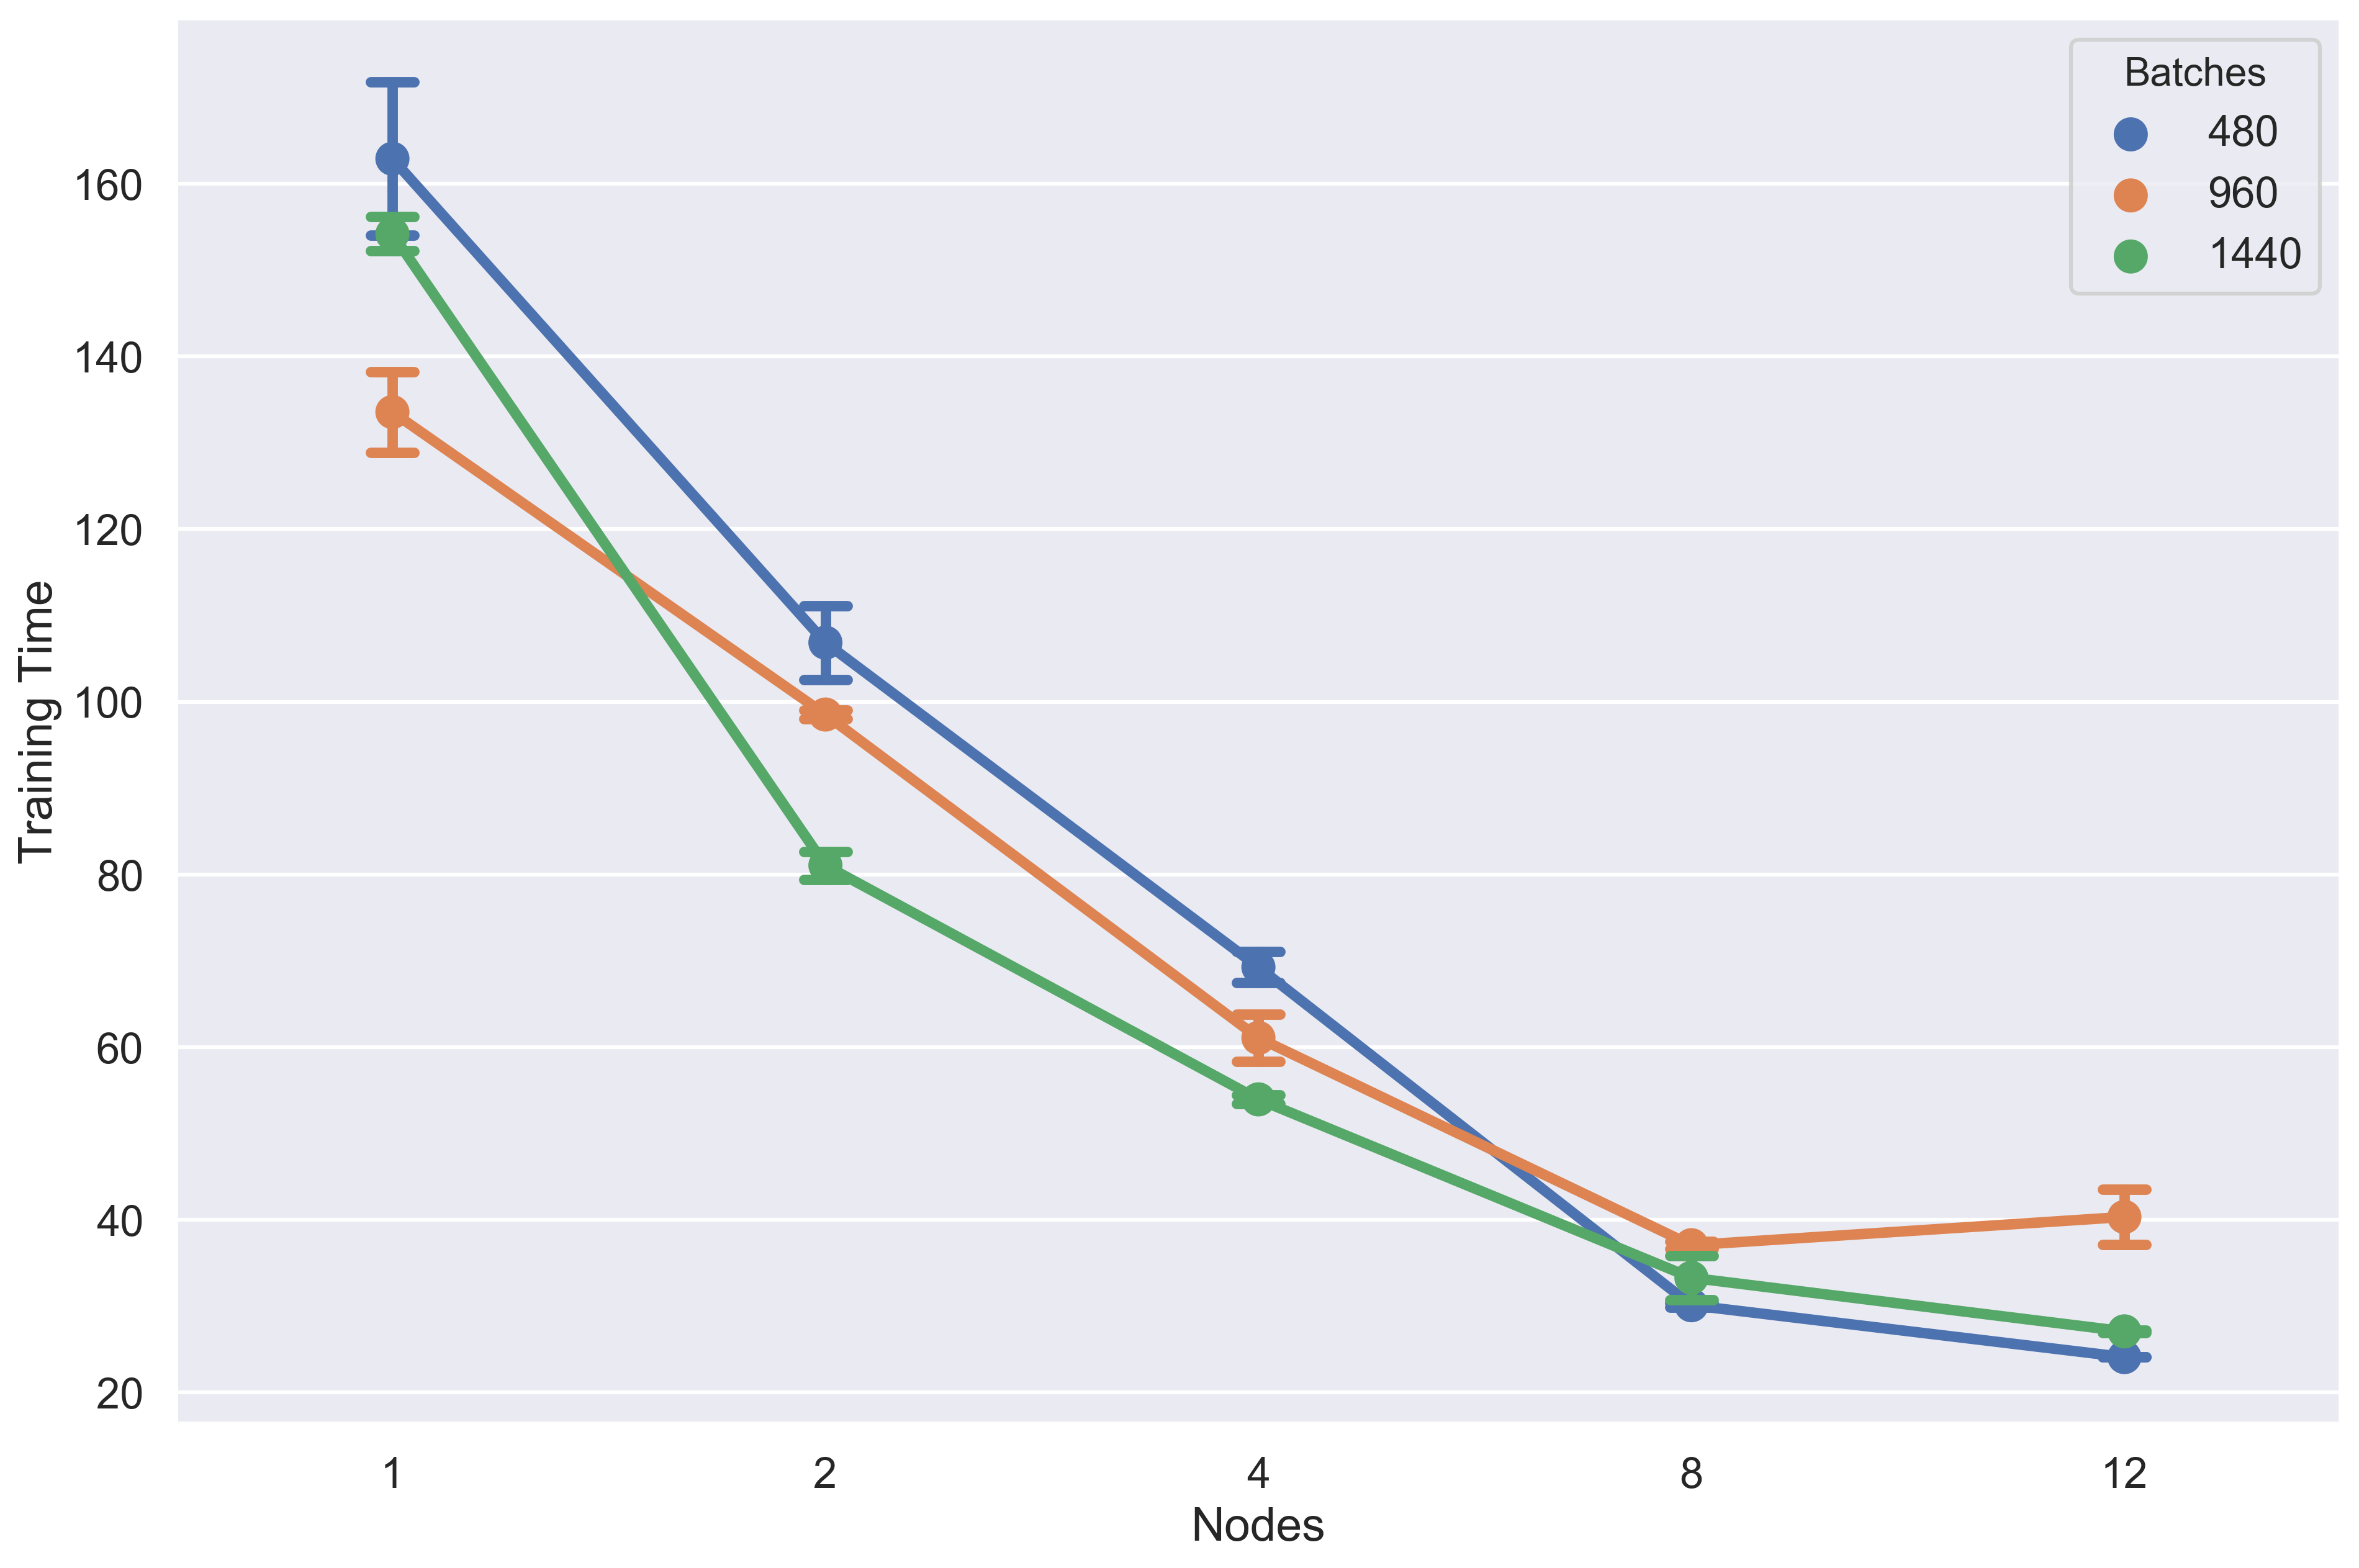

In [47]:
f = plt.figure(figsize=(15, 10), dpi= 300)
sns.pointplot(x="Nodes", y="Training Time", hue="Batches", data=distributed, ci="sd", capsize=0.1)

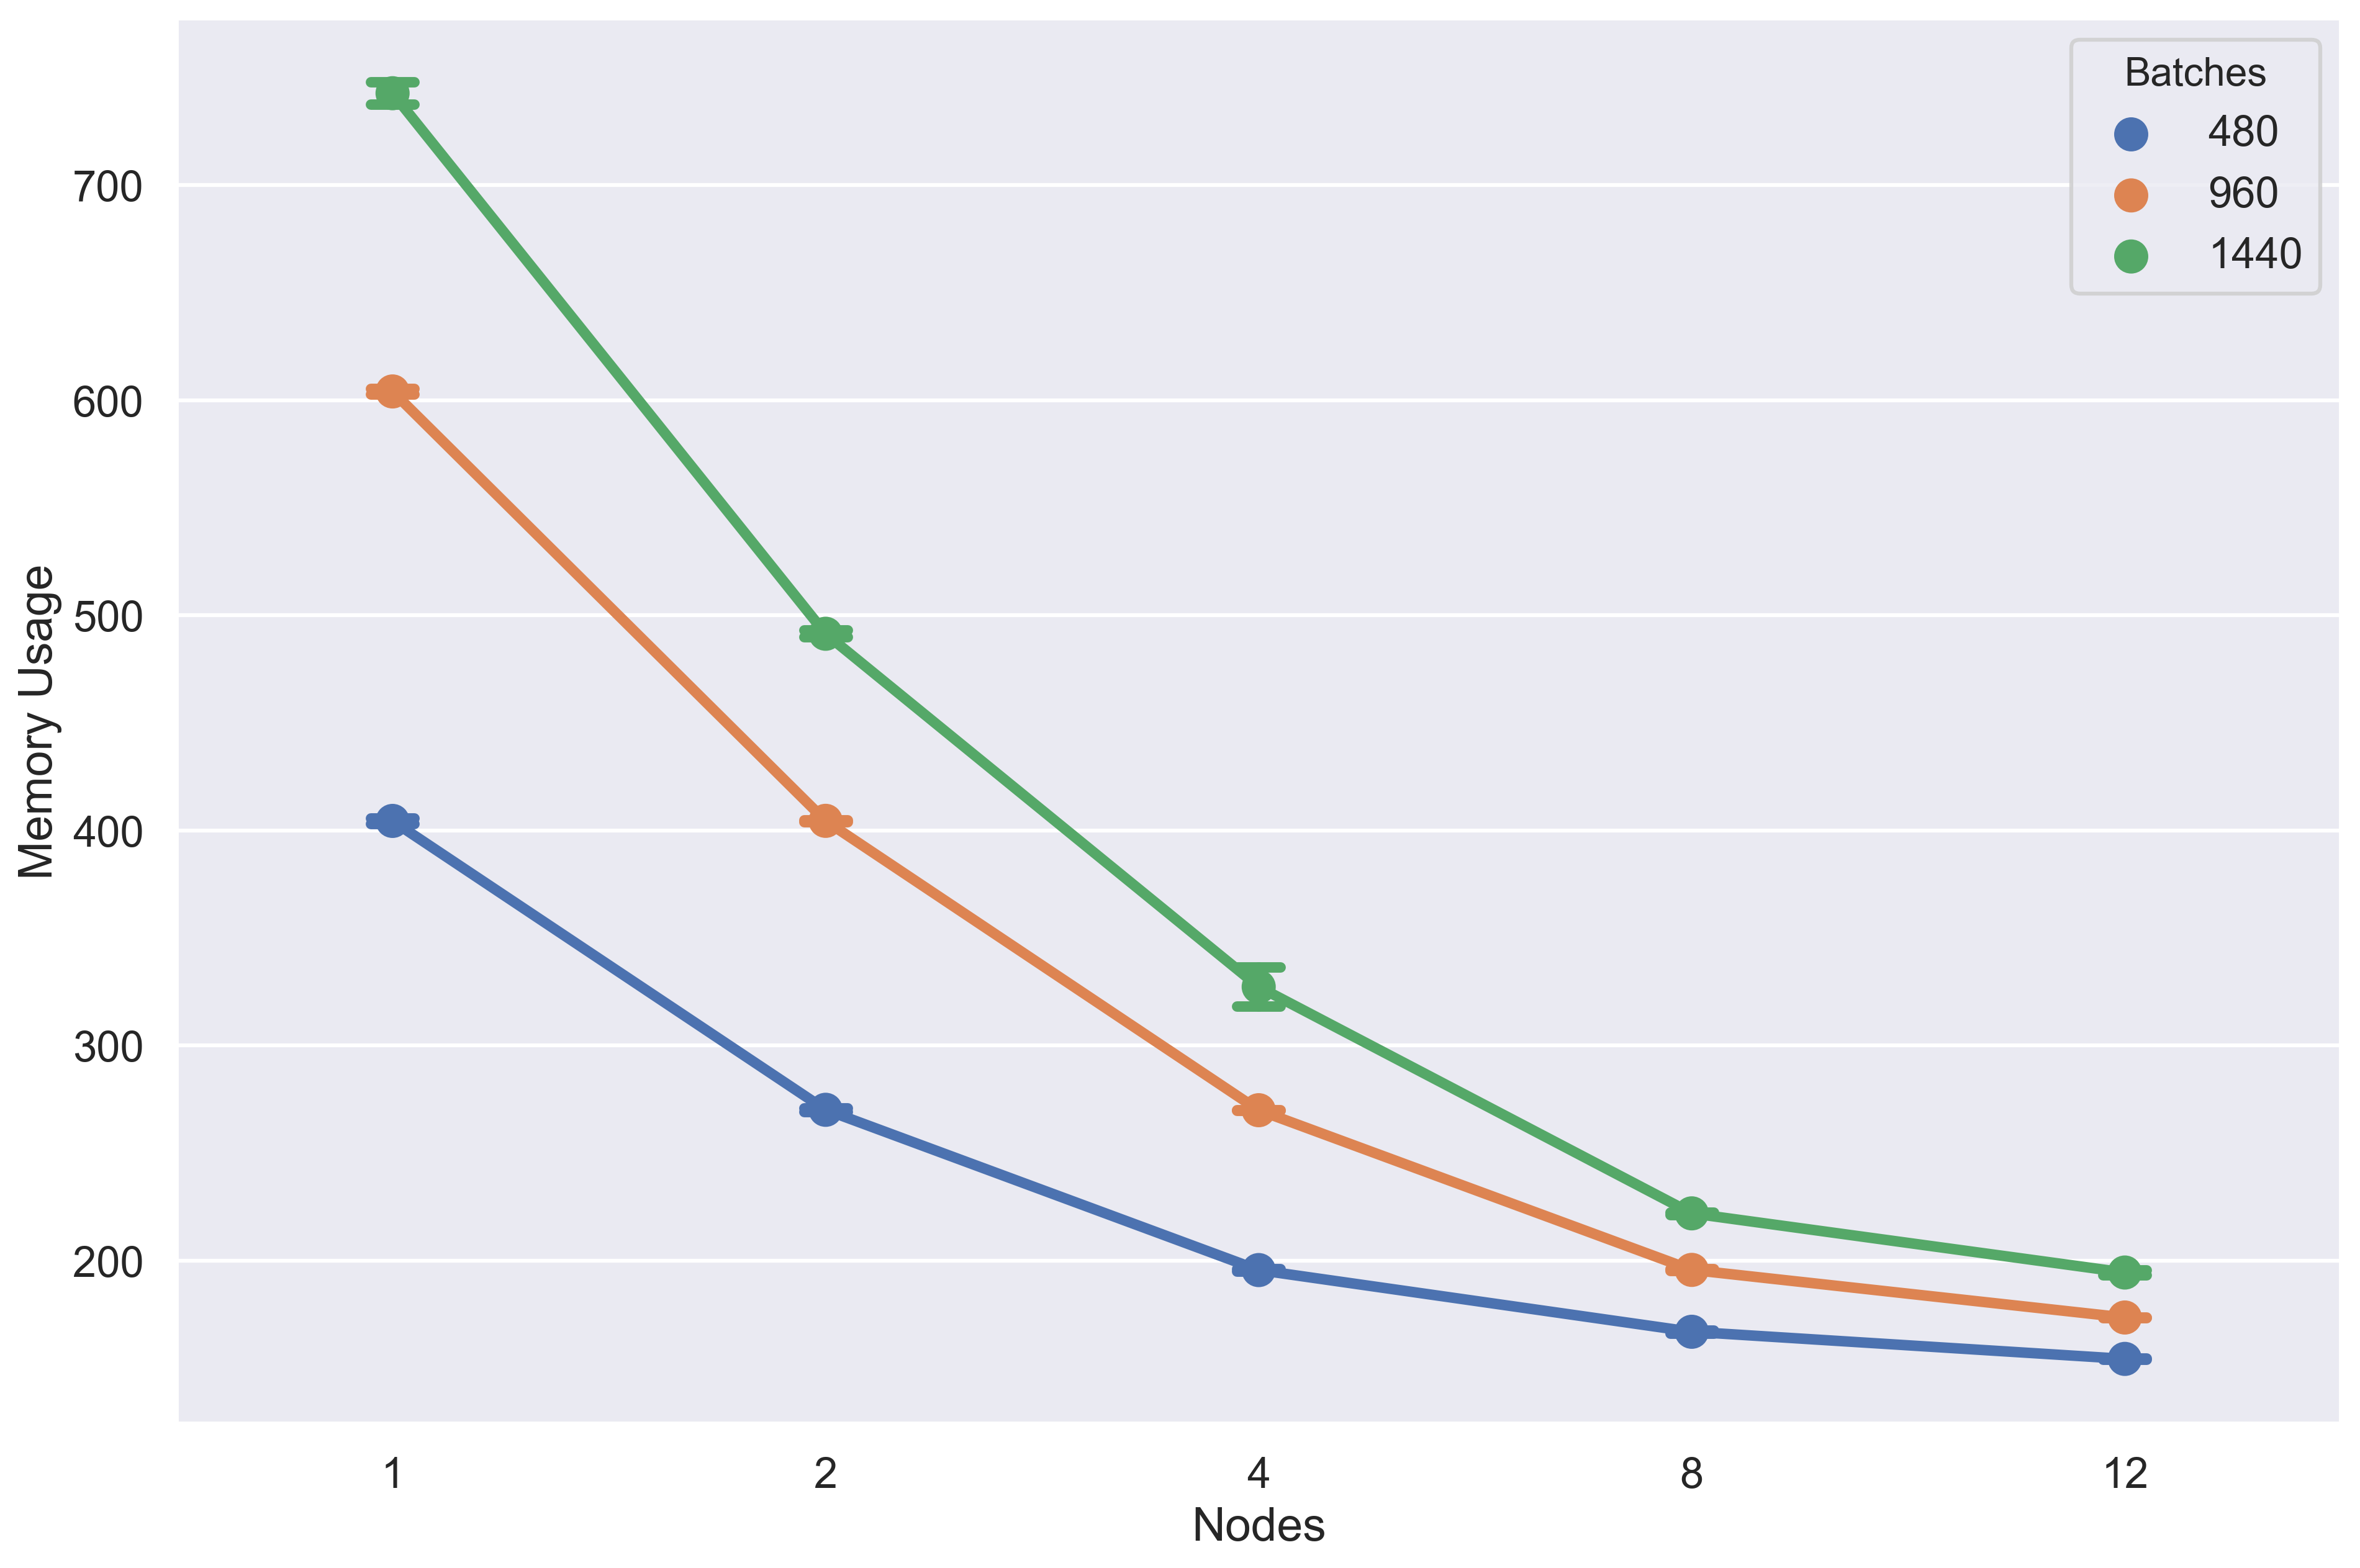

In [48]:
f = plt.figure(figsize=(15, 10), dpi= 300)
sns.pointplot(x="Nodes", y="Memory Usage", hue="Batches", data=distributed, ci="sd", capsize=0.1)